# COGS 108 - EDA Checkpoint

# Names

- Angkitha Anguraj
- Christian Goodale
- Immanuel Tran
- Camille Yabut
- Sophia Yonus

<a id='research_question'></a>
# Research Question

Is there a relationship between the **number of new enrollees** in the University of California (UC) schools and the **rental prices** of the county where the UC school is located in the years 2010-2021? Additionally, what other factors, such as college ranking and median household income, affect the location’s rental price? 

# Setup

In [1]:
# import libraries 
import numpy as np
import pandas as pd
import math

# packages helpful for webscraping
import requests
import bs4
from bs4 import BeautifulSoup

!pip3 install lxml

# import seaborn and apply its plotting styles
import seaborn as sns
sns.set(font_scale=1.5, style="white")

# import matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style

# set plotting size parameter
plt.rcParams['figure.figsize'] = (15, 10)

#improve resolution
%config InlineBackend.figure_format ='retina'

# import warnings 
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 104)

# import statmodels & patsy
import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

Defaulting to user installation because normal site-packages is not writeable


# Data Cleaning

## 1. Admissions Data

In [2]:
# define a function to clean data
def clean_admissions(s):
    
    df = pd.read_csv(s)
    
    df = df[df.Category == 'Enrollees']
    
    df = df[df.Ethnicity == 'All'].reset_index()
    
    df = df.drop(columns = ['index', 'Category', 'Ethnicity', 'Perc FR'])
    
    df = df.rename(columns = {'Academic Yr':'Year'})
    
    return df

In [3]:
Berk_data = clean_admissions('https://raw.githubusercontent.com/cgoodale01/Admissions-Data/main/BerkAdmissions.csv')
Davis_data = clean_admissions('https://raw.githubusercontent.com/cgoodale01/Admissions-Data/main/DavisAdmissions.csv')
Irvine_data = clean_admissions('https://raw.githubusercontent.com/cgoodale01/Admissions-Data/main/IrvineAdmissions.csv')
Merced_data = clean_admissions('https://raw.githubusercontent.com/cgoodale01/Admissions-Data/main/MercedAdmissions.csv')
LosAngeles_data = clean_admissions('https://raw.githubusercontent.com/cgoodale01/Admissions-Data/main/LAAdmissions.csv')
Riverside_data = clean_admissions('https://raw.githubusercontent.com/cgoodale01/Admissions-Data/main/RiversideAdmissions.csv')
SanDiego_data = clean_admissions('https://raw.githubusercontent.com/cgoodale01/Admissions-Data/main/SDAdmissions.csv')
SantaBarbara_data = clean_admissions('https://raw.githubusercontent.com/cgoodale01/Admissions-Data/main/SBAdmissions.csv')
SantaCruz_data = clean_admissions('https://raw.githubusercontent.com/cgoodale01/Admissions-Data/main/SCAdmissions.csv')

In [4]:
Berk_data = Berk_data.rename(columns = {'FilteredCountFR': "Berkeley Enrolls"})
Davis_data = Davis_data.rename(columns = {'FilteredCountFR': "Davis Enrolls"})
Irvine_data = Irvine_data.rename(columns = {'FilteredCountFR': "Irvine Enrolls"})
Merced_data = Merced_data.rename(columns = {'FilteredCountFR': "Merced Enrolls"})
LosAngeles_data = LosAngeles_data.rename(columns = {'FilteredCountFR': "Los Angeles Enrolls"})
Riverside_data = Riverside_data.rename(columns = {'FilteredCountFR': "Riverside Enrolls"})
SanDiego_data = SanDiego_data.rename(columns = {'FilteredCountFR': "San Diego Enrolls"})
SantaBarbara_data = SantaBarbara_data.rename(columns = {'FilteredCountFR': "Santa Barbara Enrolls"})
SantaCruz_data = SantaCruz_data.rename(columns = {'FilteredCountFR': "Santa Cruz Enrolls"})

In [5]:
merge1 = pd.merge(Berk_data, Davis_data, on = 'Year')
merge2 = pd.merge(merge1, Irvine_data, on = 'Year')
merge_oops = pd.merge(merge2, Merced_data, on = 'Year')
merge3 = pd.merge(merge_oops, LosAngeles_data, on = 'Year')
merge4 = pd.merge(merge3, Riverside_data, on = 'Year')
merge5 = pd.merge(merge4, SanDiego_data, on = 'Year')
merge6 = pd.merge(merge5, SantaBarbara_data, on = 'Year')
merge_all = pd.merge(merge6, SantaCruz_data, on = 'Year')

In [6]:
merge_all

,Year,Berkeley Enrolls,Davis Enrolls,Irvine Enrolls,Merced Enrolls,Los Angeles Enrolls,Riverside Enrolls,San Diego Enrolls,Santa Barbara Enrolls,Santa Cruz Enrolls
0,2021,6931,7482,6489,2410.0,6584,5203,7543,4898,4187
1,2020,6117,6144,5765,1951.0,6386,4857,6449,4847,4193
2,2019,6454,5957,6069,2105.0,5920,4777,6023,4935,3712
3,2018,6012,6393,5793,2214.0,6240,4529,6707,5094,3695
4,2017,6379,5868,6545,2292.0,6038,4599,5699,4539,4048
5,2016,6252,5762,6551,2048.0,6545,5358,5746,4996,4221
6,2015,5550,5369,5756,1788.0,5678,4029,5292,4474,3620
7,2014,5466,5377,5435,1551.0,5764,4280,4922,4738,4035
8,2013,4706,5113,5460,1654.0,5697,4201,5228,4624,3301
9,2012,4162,5208,5077,1492.0,5620,4034,4573,4741,3827


In [7]:
merge_flip = merge_all.loc[::-1].reset_index()
UC_admissions = merge_flip.drop(columns = ['index'])

In [8]:
UC_admissions

,Year,Berkeley Enrolls,Davis Enrolls,Irvine Enrolls,Merced Enrolls,Los Angeles Enrolls,Riverside Enrolls,San Diego Enrolls,Santa Barbara Enrolls,Santa Cruz Enrolls
0,2010,4109,4501,4411,1339.0,4636,4469,3947,3720,3290
1,2011,4443,4705,5115,1442.0,5825,3664,3444,4098,3607
2,2012,4162,5208,5077,1492.0,5620,4034,4573,4741,3827
3,2013,4706,5113,5460,1654.0,5697,4201,5228,4624,3301
4,2014,5466,5377,5435,1551.0,5764,4280,4922,4738,4035
5,2015,5550,5369,5756,1788.0,5678,4029,5292,4474,3620
6,2016,6252,5762,6551,2048.0,6545,5358,5746,4996,4221
7,2017,6379,5868,6545,2292.0,6038,4599,5699,4539,4048
8,2018,6012,6393,5793,2214.0,6240,4529,6707,5094,3695
9,2019,6454,5957,6069,2105.0,5920,4777,6023,4935,3712


## 2. Median Rent Data

We cleaned up the CSV files by removing unneccessary columns, renaming the columns, and adding in the year for each data set.

In [9]:
def clean_rent(csv, year):
    df = pd.read_csv(csv)
    df = pd.DataFrame(df)
    df = df.drop(columns=['United States!!Estimate',
                       'United States!!Margin of Error', 
                       'California!!Estimate',
                       'California!!Margin of Error', 
                       'Alameda County, California!!Margin of Error', 
                       'Los Angeles County, California!!Margin of Error', 
                       'Merced County, California!!Margin of Error',
                       'Orange County, California!!Margin of Error', 
                       'Riverside County, California!!Margin of Error',
                       'San Diego County, California!!Margin of Error',
                       'Santa Barbara County, California!!Margin of Error',
                       'Santa Cruz County, California!!Margin of Error', 
                       'Yolo County, California!!Margin of Error'])
    df = df.rename(columns={'Label (Grouping)':'Year',
                            'Alameda County, California!!Estimate':'Alameda County', 
                            'Los Angeles County, California!!Estimate':'Los Angeles County',
                            'Merced County, California!!Estimate':'Merced County',
                            'Orange County, California!!Estimate':'Orange County',
                            'Riverside County, California!!Estimate':'Riverside County',
                            'San Diego County, California!!Estimate':'San Diego County',
                            'Santa Barbara County, California!!Estimate':'Santa Barbara County',
                            'Santa Cruz County, California!!Estimate':'Santa Cruz County',
                            'Yolo County, California!!Estimate':'Yolo County'
                    })
    df['Year'] = [year]

    return df

In [10]:
rent_2021 = clean_rent('https://raw.githubusercontent.com/cpyabut/Data-Sets/main/ACSDT1Y2021.csv', '2021')
rent_2020 = clean_rent('https://raw.githubusercontent.com/cpyabut/Data-Sets/main/ACSDT5Y2020.csv', '2020')
rent_2019 = clean_rent('https://raw.githubusercontent.com/cpyabut/Data-Sets/main/ACSDT1Y2019.csv', '2019')
rent_2018 = clean_rent('https://raw.githubusercontent.com/cpyabut/Data-Sets/main/ACSDT1Y2018.csv', '2018')
rent_2017 = clean_rent('https://raw.githubusercontent.com/cpyabut/Data-Sets/main/ACSDT1Y2017.csv', '2017')
rent_2016 = clean_rent('https://raw.githubusercontent.com/cpyabut/Data-Sets/main/ACSDT1Y2016.csv', '2016')
rent_2015 = clean_rent('https://raw.githubusercontent.com/cpyabut/Data-Sets/main/ACSDT1Y2015.csv', '2015')
rent_2014 = clean_rent('https://raw.githubusercontent.com/cpyabut/Data-Sets/main/ACSDT1Y2014.csv', '2014')
rent_2013 = clean_rent('https://raw.githubusercontent.com/cpyabut/Data-Sets/main/ACSDT1Y2013.csv', '2013')
rent_2012 = clean_rent('https://raw.githubusercontent.com/cpyabut/Data-Sets/main/ACSDT1Y2012.csv', '2012')
rent_2011 = clean_rent('https://raw.githubusercontent.com/cpyabut/Data-Sets/main/ACSDT1Y2011.csv', '2011')
rent_2010 = clean_rent('https://raw.githubusercontent.com/cpyabut/Data-Sets/main/ACSDT1Y2010.csv', '2010')

Then, concatenated all the different datasets into one data frame. 

In [11]:
rent_data = pd.concat([rent_2010, 
                       rent_2011, 
                       rent_2012, 
                       rent_2013, 
                       rent_2014, 
                       rent_2015,
                       rent_2016,
                       rent_2017,
                       rent_2018,
                       rent_2019, 
                       rent_2020, 
                       rent_2021], ignore_index=True)

rent_data

,Year,Alameda County,Los Angeles County,Merced County,Orange County,Riverside County,San Diego County,Santa Barbara County,Santa Cruz County,Yolo County
0,2010,"1,198","1,147",807,"1,402","1,121","1,249","1,267","1,284","1,056"
1,2011,"1,244","1,161",814,"1,430","1,101","1,237","1,265","1,358",987
2,2012,"1,265","1,175",834,"1,465","1,129","1,253","1,324","1,474","1,011"
3,2013,"1,335","1,205",864,"1,499","1,164","1,289","1,336","1,350","1,110"
4,2014,"1,391","1,239",858,"1,572","1,196","1,373","1,395","1,477","1,094"
5,2015,"1,513","1,279",874,"1,624","1,195","1,427","1,419","1,442","1,160"
6,2016,"1,622","1,330",899,"1,722","1,275","1,504","1,542","1,594","1,210"
7,2017,"1,745","1,402","1,003","1,786","1,313","1,598","1,587","1,680","1,231"
8,2018,"1,875","1,479","1,023","1,872","1,374","1,668","1,653","1,685","1,320"
9,2019,"1,982","1,577","1,097","1,929","1,497","1,758","1,660","1,785","1,489"


Finally, we changed the data type to integers for all columns. 

In [12]:
# check data types 
rent_data.dtypes

Year                    object
Alameda County          object
Los Angeles County      object
Merced County           object
Orange County           object
Riverside County        object
San Diego County        object
Santa Barbara County    object
Santa Cruz County       object
Yolo County             object
dtype: object

In [13]:
# reassign object to int data type for year column
rent_data['Year'] = rent_data['Year'].astype(int)

In [14]:
# Merced and Yolo County have some values that have commas and others that do not
# define a function to convert all values to integers, regardless if they have a comma or not
def convert_int(value):
    
    value = str(value)
    
    if len(value) <= 3:
        output = int(value)
    else:
        output = value.replace(',','')
        output = int(output)
    
    return output

In [15]:
# apply function to county columns
rent_data['Alameda County'] = rent_data['Alameda County'].apply(convert_int)
rent_data['Los Angeles County'] = rent_data['Los Angeles County'].apply(convert_int)
rent_data['Merced County'] = rent_data['Merced County'].apply(convert_int)
rent_data['Orange County'] = rent_data['Orange County'].apply(convert_int)
rent_data['Riverside County'] = rent_data['Riverside County'].apply(convert_int)
rent_data['San Diego County'] = rent_data['San Diego County'].apply(convert_int)
rent_data['Santa Barbara County'] = rent_data['Santa Barbara County'].apply(convert_int)
rent_data['Santa Cruz County'] = rent_data['Santa Cruz County'].apply(convert_int)
rent_data['Yolo County'] = rent_data['Yolo County'].apply(convert_int)

In [16]:
# check if all data types are integers
rent_data.dtypes

Year                    int64
Alameda County          int64
Los Angeles County      int64
Merced County           int64
Orange County           int64
Riverside County        int64
San Diego County        int64
Santa Barbara County    int64
Santa Cruz County       int64
Yolo County             int64
dtype: object

In [17]:
# display data frame
rent_data

,Year,Alameda County,Los Angeles County,Merced County,Orange County,Riverside County,San Diego County,Santa Barbara County,Santa Cruz County,Yolo County
0,2010,1198,1147,807,1402,1121,1249,1267,1284,1056
1,2011,1244,1161,814,1430,1101,1237,1265,1358,987
2,2012,1265,1175,834,1465,1129,1253,1324,1474,1011
3,2013,1335,1205,864,1499,1164,1289,1336,1350,1110
4,2014,1391,1239,858,1572,1196,1373,1395,1477,1094
5,2015,1513,1279,874,1624,1195,1427,1419,1442,1160
6,2016,1622,1330,899,1722,1275,1504,1542,1594,1210
7,2017,1745,1402,1003,1786,1313,1598,1587,1680,1231
8,2018,1875,1479,1023,1872,1374,1668,1653,1685,1320
9,2019,1982,1577,1097,1929,1497,1758,1660,1785,1489


## 3. College Ranking Data

For the 2010-2017 data, we used the pandas `.read_html()` function to get a list of the tables from the webpage and manually found the particular table of interest through cross referencing with the website. Since this table differs from more recent data (2018 onwards), we had to rename the columns, drop those we did not need, and filter out the non-UC schools.

In [18]:
# use pandas .read_html() function to get list of tables from the webpage
uc_acc_2017 = pd.read_html('https://accountability.universityofcalifornia.edu/2017/chapters/chapter-14.html')
uc_acc_2017

# find particular table (cross reference with website) + get location using list index 
# reassign to new variable, rank_2010_2017
rank_2010_2017 = uc_acc_2017[5]
rank_2010_2017;

In [19]:
# rename columns to the years
rank_2010_2017 = rank_2010_2017.rename(columns={0:'UC',
                                                1:'2008',
                                                2:'2009',
                                                3:'2010',
                                                4:'2011',
                                                5:'2012',
                                                6:'2013',
                                                7:'2014',
                                                8:'2015',
                                                9:'2016',
                                                10:'2017'})

# drop row 0 + columns 2008 and 2009 which we do not need
rank_2010_2017 = rank_2010_2017.drop(index=0, columns=['2008','2009'])

In [20]:
# filter data frame by excluding non-UC schools 
# reset index then drop index column
UC_Campus = ['Berkeley','Los Angeles',
             'Santa Barbara','Irvine',
             'San Diego','Davis','Santa Cruz',
             'Riverside','Merced']
rank_2010_2017 = (rank_2010_2017[rank_2010_2017['UC'].isin(UC_Campus)]
                  .reset_index()
                  .drop(columns=['index'])
                 )

# display cleaned up table
rank_2010_2017;

For the 2018-2021 ranking data, we used the same pandas `.read_html()` function to get the list of tables and manually found our table of interest for each year. To clean the data, we dropped columns we did not need, renamed them, and manually reordered the rows of the UC schools to be consistent with the 2010-2017 data. 

In [21]:
# use pandas .read_html() function to get list of tables from the webpage
uc_acc_2018 = pd.read_html('https://accountability.universityofcalifornia.edu/2018/chapters/chapter-13.html')

# find particular table (cross reference with website) + get location using list index 
# reassign to new variable, rank_2018
rank_2018 = uc_acc_2018[1]
rank_2018;

In [22]:
# drop row 0 and column 1 which we do not need; keep column 2 since we want national ranking
# rename columns to 'UC' and ranking year '2018'
rank_2018 = (rank_2018.drop(index=0, columns=[1])
             .rename(columns={0:'UC', 2:'2018'})
             .reset_index()
             .drop(columns=['index'])
            )
rank_2018;

In [23]:
# use pandas .read_html() function to get list of tables from the webpage
uc_acc_2019 = pd.read_html('https://accountability.universityofcalifornia.edu/2019/chapters/chapter-13.html')
uc_acc_2019

# find particular table (cross reference with website) + get location using list index 
# reassign to new variable, rank_2019
rank_2019 = uc_acc_2019[2]
rank_2019;

In [24]:
# drop row 0 and column 1 which we do not need; keep column 2 since we want national ranking
# rename columns to 'UC' and ranking year '2019'
rank_2019 = (rank_2019.drop(index=0, columns=[1])
             .rename(columns={0:'UC', 2:'2019'})
             .reindex([2, 1, 3, 4, 6, 5, 7, 8, 9])
             .reset_index()
             .drop(columns=['index'])
            )
rank_2019;

In [25]:
# use pandas .read_html() function to get list of tables from the webpage
uc_acc_2020 = pd.read_html('https://accountability.universityofcalifornia.edu/2020/chapters/chapter-13.html')
uc_acc_2020

# find particular table (cross reference with website) + get location using list index 
# reassign to new variable, rank_2020
rank_2020 = uc_acc_2020[1]
rank_2020;

In [26]:
# drop row 0 and column 1 which we do not need; keep column 2 since we want national ranking
# rename columns to 'UC' and ranking year '2020'
rank_2020 = (rank_2020.drop(index=0, columns=[1])
             .rename(columns={0:'UC', 2:'2020'})
             .reindex([2, 1, 3, 4, 5, 6, 7, 8, 9])
             .reset_index()
             .drop(columns=['index'])
            )
rank_2020;

In [27]:
# use pandas .read_html() function to get list of tables from the webpage
uc_acc_2021 = pd.read_html('https://accountability.universityofcalifornia.edu/2021/chapters/chapter-13.html')
uc_acc_2021

# find particular table (cross reference with website) + get location using list index 
# reassign to new variable, rank_2021
rank_2021 = uc_acc_2021[1]
rank_2021;

In [28]:
# drop row 0 and column 1 which we do not need; keep column 2 since we want national ranking
# rename columns to 'UC' and ranking year '2021'
rank_2021 = (rank_2021.drop(index=0, columns=[1])
             .rename(columns={0:'UC', 2:'2021'})
             .reindex([2, 1, 3, 4, 5, 6, 9, 7, 8])
             .reset_index()
             .drop(columns=['index'])
            )
rank_2021;

Then, after getting rankings for each year, we concatenated the columns into one table and dropped the repeating information (such as the UC school's name), and renamed the columns to the years.

In [29]:
# use pd.concat() to put together the different dataframes 
rank_data = pd.concat([rank_2010_2017,
                      rank_2018,
                      rank_2019,
                      rank_2020,
                      rank_2021], axis=1, ignore_index=True)

# drop columns we do not need, and rename columns to be year 
rank_data = (rank_data
             .drop(columns=[9, 11, 13, 15])
             .rename(columns={0:'UC',
                              1:'2010',
                              2:'2011',
                              3:'2012',
                              4:'2013',
                              5:'2014',
                              6:'2015',
                              7:'2016',
                              8:'2017',
                              10:'2018',
                              12:'2019',
                              14:'2020',
                              16:'2021',
                              })
            ) 
rank_data

,UC,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Berkeley,21,22,21,21,20,20,20,20,21,22,22,22
1,Los Angeles,24,25,25,24,23,23,23,24,21,19,20,20
2,Santa Barbara,42,39,42,41,41,40,37,37,37,30,34,30
3,Irvine,46,41,45,44,49,42,39,39,42,33,36,35*
4,San Diego,35,35,37,38,39,37,39,44,42,41,37,35*
5,Davis,42,39,38,38,39,38,41,44,46,38,39,39
6,Santa Cruz,71,72,75,77,86,85,82,79,81,70,84,97*
7,Riverside,96,94,97,101,112,113,121,118,124,85,91,88
8,Merced,nr,nr,nr,nr,nr,nr,nr,152,165,136,104,97*


Transpose the table so that the years are the rows, similar to other created data frames. 

In [30]:
rank_data = rank_data.transpose()
rank_data

,0,1,2,3,4,5,6,7,8
UC,Berkeley,Los Angeles,Santa Barbara,Irvine,San Diego,Davis,Santa Cruz,Riverside,Merced
2010,21,24,42,46,35,42,71,96,nr
2011,22,25,39,41,35,39,72,94,nr
2012,21,25,42,45,37,38,75,97,nr
2013,21,24,41,44,38,38,77,101,nr
2014,20,23,41,49,39,39,86,112,nr
2015,20,23,40,42,37,38,85,113,nr
2016,20,23,37,39,39,41,82,121,nr
2017,20,24,37,39,44,44,79,118,152
2018,21,21,37,42,42,46,81,124,165


In [31]:
rank_data = (rank_data.rename(columns={0:'Berkeley',
                              1:'Los Angeles',
                              2:'Santa Barbara',
                              3:'Irvine',
                              4:'San Diego',
                              5:'Davis',
                              6:'Santa Cruz',
                              7:'Riverside',
                              8:'Merced',
                              })
             .drop(index='UC')
             .reset_index()
             .rename(columns={'index':'Year'})
            )
rank_data

,Year,Berkeley,Los Angeles,Santa Barbara,Irvine,San Diego,Davis,Santa Cruz,Riverside,Merced
0,2010,21,24,42,46,35,42,71,96,nr
1,2011,22,25,39,41,35,39,72,94,nr
2,2012,21,25,42,45,37,38,75,97,nr
3,2013,21,24,41,44,38,38,77,101,nr
4,2014,20,23,41,49,39,39,86,112,nr
5,2015,20,23,40,42,37,38,85,113,nr
6,2016,20,23,37,39,39,41,82,121,nr
7,2017,20,24,37,39,44,44,79,118,152
8,2018,21,21,37,42,42,46,81,124,165
9,2019,22,19,30,33,41,38,70,85,136


With our current dataframe there are three issues to deal with: the nr values of Merced, the asterisks in the 2021 column, and the object data type. To address these, we created a function that will take in the column value and deal with the issues accordingly.

In [32]:
rank_data.dtypes

Year             object
Berkeley         object
Los Angeles      object
Santa Barbara    object
Irvine           object
San Diego        object
Davis            object
Santa Cruz       object
Riverside        object
Merced           object
dtype: object

In [33]:
# define a function to convert the values to floats and change 'nr' to NaN
def rank_convert_float(value):
    
    value = str(value)
    
    if 'n' in value:
        output = np.nan
    elif '*' in value:
        output = value.replace('*','')
        output = float(output)
    else: 
        output = float(value)
    
    return output

In [34]:
rank_data['Year'] = rank_data['Year'].apply(rank_convert_float)
rank_data['Berkeley'] = rank_data['Berkeley'].apply(rank_convert_float)
rank_data['Los Angeles'] = rank_data['Los Angeles'].apply(rank_convert_float)
rank_data['Santa Barbara'] = rank_data['Santa Barbara'].apply(rank_convert_float)
rank_data['Irvine'] = rank_data['Irvine'].apply(rank_convert_float)
rank_data['San Diego'] = rank_data['San Diego'].apply(rank_convert_float)
rank_data['Davis'] = rank_data['Davis'].apply(rank_convert_float)
rank_data['Santa Cruz'] = rank_data['Santa Cruz'].apply(rank_convert_float)
rank_data['Riverside'] = rank_data['Riverside'].apply(rank_convert_float)
rank_data['Merced'] = rank_data['Merced'].apply(rank_convert_float)

Finally, we will check that the data frame types are all floats and that the data frame is sufficiently clean. Note that we did not remove the NaN values of Merced as we will deal with this later during data analysis. 

In [35]:
rank_data.dtypes

Year             float64
Berkeley         float64
Los Angeles      float64
Santa Barbara    float64
Irvine           float64
San Diego        float64
Davis            float64
Santa Cruz       float64
Riverside        float64
Merced           float64
dtype: object

In [36]:
# display table 
rank_data 

,Year,Berkeley,Los Angeles,Santa Barbara,Irvine,San Diego,Davis,Santa Cruz,Riverside,Merced
0,2010.0,21.0,24.0,42.0,46.0,35.0,42.0,71.0,96.0,NaN
1,2011.0,22.0,25.0,39.0,41.0,35.0,39.0,72.0,94.0,NaN
2,2012.0,21.0,25.0,42.0,45.0,37.0,38.0,75.0,97.0,NaN
3,2013.0,21.0,24.0,41.0,44.0,38.0,38.0,77.0,101.0,NaN
4,2014.0,20.0,23.0,41.0,49.0,39.0,39.0,86.0,112.0,NaN
5,2015.0,20.0,23.0,40.0,42.0,37.0,38.0,85.0,113.0,NaN
6,2016.0,20.0,23.0,37.0,39.0,39.0,41.0,82.0,121.0,NaN
7,2017.0,20.0,24.0,37.0,39.0,44.0,44.0,79.0,118.0,152.0
8,2018.0,21.0,21.0,37.0,42.0,42.0,46.0,81.0,124.0,165.0
9,2019.0,22.0,19.0,30.0,33.0,41.0,38.0,70.0,85.0,136.0


## 4. Median Household Income Data

In [37]:
#defining a function to do cleaning procedures on a CSV 's'
def clean_income(s):
    
    df = pd.read_csv(s) #Read in dataset
    
    year = pd.to_datetime(df['DATE']) #Keep only year from date column
    year.dt.year
    df['DATE']= year.dt.year
    
    rel_years = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020] #Slice only relevant years
    df = df[df.DATE.isin(rel_years)].reset_index()
    
    df = df.rename(columns = {'DATE':"Year"}) #Rename Date column to Year
    
    return df

In [38]:
#Read in and clean FRED datasets for all 9 counties 2010-2020
Alameda_df = clean_income('https://raw.githubusercontent.com/cgoodale01/Median-Household-Income-Data/main/MHICA06001A052NCEN.csv')
LosAngeles_df = clean_income('https://raw.githubusercontent.com/cgoodale01/Median-Household-Income-Data/main/MHICA06037A052NCEN.csv')
Merced_df = clean_income('https://raw.githubusercontent.com/cgoodale01/Median-Household-Income-Data/main/MHICA06047A052NCEN.csv')
Orange_df = clean_income('https://raw.githubusercontent.com/cgoodale01/Median-Household-Income-Data/main/MHICA06059A052NCEN.csv')
Riverside_df = clean_income('https://raw.githubusercontent.com/cgoodale01/Median-Household-Income-Data/main/MHICA06065A052NCEN.csv')
SanDiego_df = clean_income('https://raw.githubusercontent.com/cgoodale01/Median-Household-Income-Data/main/MHICA06073A052NCEN.csv')
SantaBarbara_df = clean_income('https://raw.githubusercontent.com/cgoodale01/Median-Household-Income-Data/main/MHICA06083A052NCEN.csv')
SantaCruz_df = clean_income('https://raw.githubusercontent.com/cgoodale01/Median-Household-Income-Data/main/MHICA06087A052NCEN.csv')
Yolo_df = clean_income('https://raw.githubusercontent.com/cgoodale01/Median-Household-Income-Data/main/MHICA06113A052NCEN.csv')

In [39]:
#Merge all FRED datasets into one matching based on year
merge1 = pd.merge(Alameda_df, LosAngeles_df[['Year', 'MHICA06037A052NCEN']], on= 'Year')
merge2 = pd.merge(merge1, Merced_df[['Year', 'MHICA06047A052NCEN']], on= 'Year')
merge3 = pd.merge(merge2, Orange_df[['Year', 'MHICA06059A052NCEN']], on= 'Year')
merge4 = pd.merge(merge3, Riverside_df[['Year', 'MHICA06065A052NCEN']], on= 'Year')
merge5 = pd.merge(merge4, SanDiego_df[['Year', 'MHICA06073A052NCEN']], on= 'Year')
merge6 = pd.merge(merge5, SantaBarbara_df[['Year', 'MHICA06083A052NCEN']], on= 'Year')
merge7 = pd.merge(merge6, SantaCruz_df[['Year', 'MHICA06087A052NCEN']], on= 'Year')
merge_all_df = pd.merge(merge7, Yolo_df[['Year', 'MHICA06113A052NCEN']], on= 'Year')

In [40]:
#Rename columns so they respond to county names
Counties_dict = {'MHICA06001A052NCEN': 'Alameda',
                'MHICA06037A052NCEN': 'Los Angeles',
                'MHICA06047A052NCEN': 'Merced',
                'MHICA06059A052NCEN': 'Orange',
                'MHICA06065A052NCEN': 'Riverside',
                'MHICA06073A052NCEN': 'San Diego',
                'MHICA06083A052NCEN': 'Santa Barbara',
                'MHICA06087A052NCEN': 'Santa Cruz',
                'MHICA06113A052NCEN': 'Yolo'}
Counties_income = merge_all_df.rename(columns = Counties_dict)

In [41]:
#Drop index column
Counties_income = Counties_income.drop(columns = ['index'])

In [42]:
#Read in data for 2021 from American Community Survey

data2021 = pd.read_csv('https://raw.githubusercontent.com/cgoodale01/Median-Household-Income-Data/main/ACSDP1Y2021.DP03-2022-11-07T044023.csv')
df2021 = pd.DataFrame(data2021)

In [43]:
#Clean data only taking the estimate of Median Household Income for each county
important_col = ['Alameda County, California!!Estimate',
                 'Los Angeles County, California!!Estimate',
                 'Merced County, California!!Estimate',
                'Orange County, California!!Estimate',
                'Riverside County, California!!Estimate',
                'San Diego County, California!!Estimate',
                'Santa Barbara County, California!!Estimate',
                'Santa Cruz County, California!!Estimate',
                'Yolo County, California!!Estimate']

#Slicing only the estimate columns and not percents or margin of error and take only the Median Household Income row
#Add column for Year to match it with the 2010-2020
#Rename county columns to match with 2010-2020 data

df2021 = df2021[important_col]
df2021_income = df2021.iloc[67:68,:]
df2021_income['Year']= 2021
df2021_income = df2021_income.rename(columns = {'Alameda County, California!!Estimate':'Alameda',
                 'Los Angeles County, California!!Estimate':'Los Angeles',
                 'Merced County, California!!Estimate': 'Merced',
                'Orange County, California!!Estimate': 'Orange',
                'Riverside County, California!!Estimate': 'Riverside',
                'San Diego County, California!!Estimate': 'San Diego',
                'Santa Barbara County, California!!Estimate': 'Santa Barbara',
                'Santa Cruz County, California!!Estimate':'Santa Cruz',
                'Yolo County, California!!Estimate':'Yolo'})

In [44]:
#Append the 2021 Year data to our data for 2010-2020 and reset index
Counties_income = Counties_income.append(df2021_income, )
Counties_income = Counties_income.reset_index()
Counties_income = Counties_income.drop(columns = ['index'])

In [45]:
#Convert median household income values to integers
for x in range (1,10):
    Counties_income.iloc[11,x] = Counties_income.iloc[11,x].replace(',','')

for i in range (0,12):
    for j in range (1,10):
        Counties_income.iloc[i,j] = int(Counties_income.iloc[i,j])

In [46]:
# check data types
Counties_income.dtypes

Year              int64
Alameda          object
Los Angeles      object
Merced           object
Orange           object
Riverside        object
San Diego        object
Santa Barbara    object
Santa Cruz       object
Yolo             object
dtype: object

In [47]:
# create function to convert to integer
def inc_convert_int(i):
    output = int(i)
    return output

In [48]:
# apply function to each column
Counties_income['Alameda'] = Counties_income['Alameda'].apply(inc_convert_int)
Counties_income['Los Angeles'] = Counties_income['Los Angeles'].apply(inc_convert_int)
Counties_income['Merced'] = Counties_income['Merced'].apply(inc_convert_int)
Counties_income['Orange'] = Counties_income['Orange'].apply(inc_convert_int)
Counties_income['Riverside'] = Counties_income['Riverside'].apply(inc_convert_int)
Counties_income['San Diego'] = Counties_income['San Diego'].apply(inc_convert_int)
Counties_income['Santa Barbara'] = Counties_income['Santa Barbara'].apply(inc_convert_int)
Counties_income['Santa Cruz'] = Counties_income['Santa Cruz'].apply(inc_convert_int)
Counties_income['Yolo'] = Counties_income['Yolo'].apply(inc_convert_int)

In [49]:
# check data types
Counties_income.dtypes

Year             int64
Alameda          int64
Los Angeles      int64
Merced           int64
Orange           int64
Riverside        int64
San Diego        int64
Santa Barbara    int64
Santa Cruz       int64
Yolo             int64
dtype: object

In [50]:
# check dataframe
Counties_income

,Year,Alameda,Los Angeles,Merced,Orange,Riverside,San Diego,Santa Barbara,Santa Cruz,Yolo
0,2010,66937,52595,41730,70727,53981,59759,56243,60247,54433
1,2011,67295,52239,40016,72046,52491,59290,59494,61228,50174
2,2012,70209,52929,42552,71866,52416,60235,60683,65799,51040
3,2013,72128,54443,41003,73827,53909,61365,60803,65282,55011
4,2014,76996,55686,43818,76061,56877,66034,62116,64257,54509
5,2015,81462,59045,42879,78002,57895,67053,63049,64841,58766
6,2016,89472,61308,47442,81642,59951,70693,66360,75929,63645
7,2017,95550,64912,48036,86031,63776,76048,70651,76633,64900
8,2018,101744,67986,56169,89373,66793,78777,75646,84213,67804
9,2019,107589,72721,59733,95761,72905,83576,74530,85770,70951


# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

## 1. Description of Data

This first section seeks to describe the current data we have on admissions, median rent, college ranking, and media household income. This is done by looking at their descriptive statistics and generating a plot to observe the overall trend for each dataset. 

### 1a. Admissions Data

In [51]:
# describe dataframe
UC_admissions.describe()

,Year,Berkeley Enrolls,Davis Enrolls,Irvine Enrolls,Merced Enrolls,Los Angeles Enrolls,Riverside Enrolls,San Diego Enrolls,Santa Barbara Enrolls,Santa Cruz Enrolls
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,2015.500000,5548.416667,5656.583333,5705.500000,1857.166667,5911.083333,4500.000000,5464.416667,4642.000000,3811.333333
std,3.605551,971.745894,806.595253,655.900145,362.150605,526.079575,497.434144,1161.478561,396.257951,329.585782
min,2010.000000,4109.000000,4501.000000,4411.000000,1339.000000,4636.000000,3664.000000,3444.000000,3720.000000,3290.000000
25%,2012.750000,4640.250000,5184.250000,5355.000000,1536.250000,5692.250000,4159.250000,4834.750000,4522.750000,3616.750000
50%,2015.500000,5781.000000,5569.500000,5760.500000,1869.500000,5872.500000,4499.000000,5495.500000,4739.500000,3769.500000
75%,2018.250000,6283.750000,6003.750000,6174.000000,2132.250000,6276.500000,4797.000000,6129.500000,4907.250000,4082.750000
max,2021.000000,6931.000000,7482.000000,6551.000000,2410.000000,6584.000000,5358.000000,7543.000000,5094.000000,4221.000000


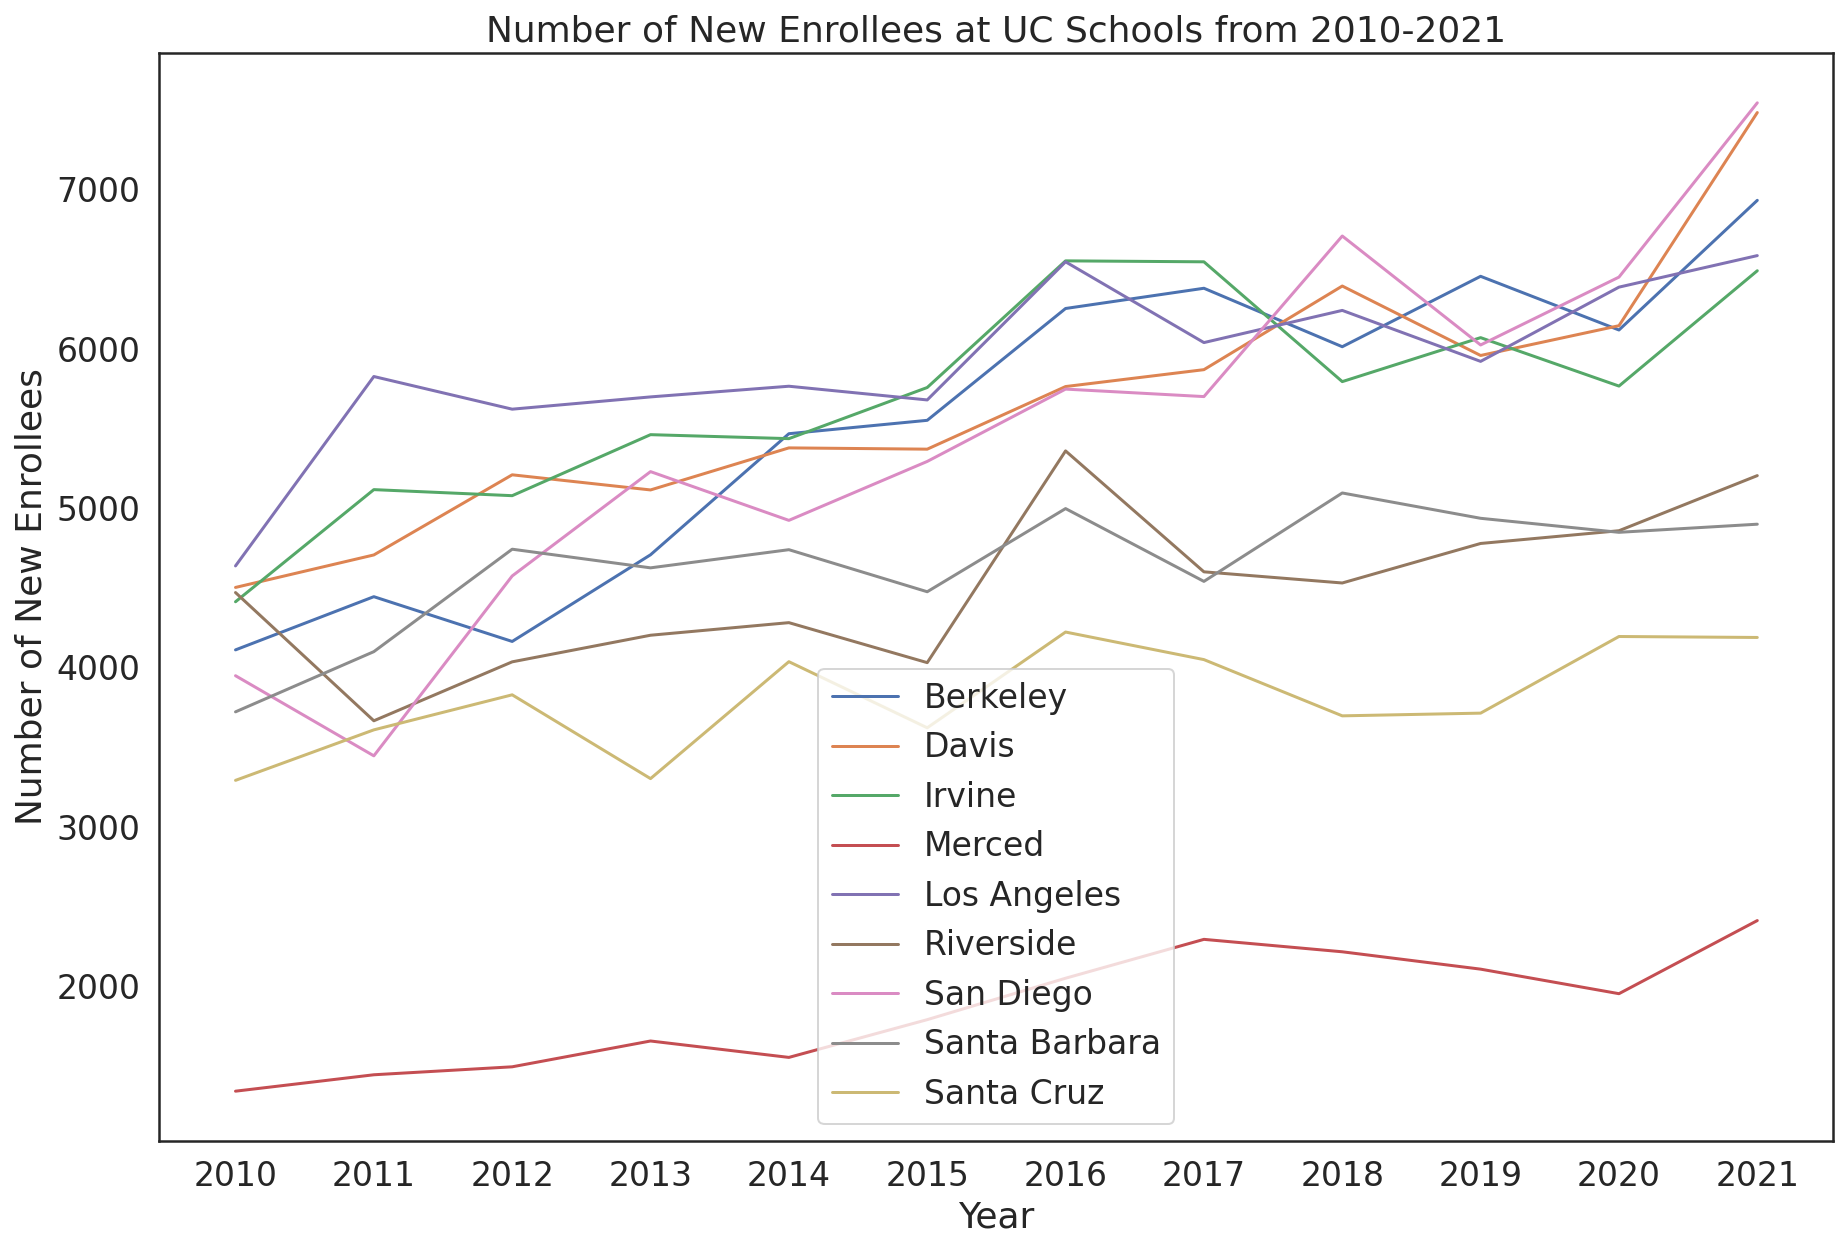

In [52]:
# plot each column into one figure
plt.figure(figsize=(15,10))
plt.xticks(UC_admissions['Year'])

berk_enroll = sns.lineplot(data = UC_admissions, x = 'Year', y = 'Berkeley Enrolls', label='Berkeley')
davis_enroll = sns.lineplot(data = UC_admissions, x = 'Year', y = 'Davis Enrolls', label = 'Davis')
irv_enroll = sns.lineplot(data = UC_admissions, x = 'Year', y = 'Irvine Enrolls', label='Irvine')
merc_enroll = sns.lineplot(data = UC_admissions, x = 'Year', y = 'Merced Enrolls', label='Merced')
la_enroll = sns.lineplot(data = UC_admissions, x = 'Year', y = 'Los Angeles Enrolls', label='Los Angeles')
riv_enroll = sns.lineplot(data = UC_admissions, x = 'Year', y = 'Riverside Enrolls', label='Riverside')
sd_enroll = sns.lineplot(data = UC_admissions, x = 'Year', y = 'San Diego Enrolls', label='San Diego')
sb_enroll = sns.lineplot(data = UC_admissions, x = 'Year', y = 'Santa Barbara Enrolls', label='Santa Barbara')
sc_enroll = sns.lineplot(data = UC_admissions, x = 'Year', y = 'Santa Cruz Enrolls', label='Santa Cruz')

berk_enroll.set_ylabel('Number of New Enrollees')
berk_enroll.set_title('Number of New Enrollees at UC Schools from 2010-2021')

admissions_plot = plt.gcf()

This ``admissions plot`` was made to see the general trend of the number of new enrolless from 2010-2021. As seen in the plot, the number of new enrollees seem to be fluctuating every year from 2010-2020. Significantly, however, the **number of new enrollees increases for most UCs** as we reach past 2020, with the exception being Santa Cruz which has a barley noticeable decrease in admissions.

### 1b. Median Rent Data

In [53]:
# describe dataframe
rent_data.describe()

,Year,Alameda County,Los Angeles County,Merced County,Orange County,Riverside County,San Diego County,Santa Barbara County,Santa Cruz County,Yolo County
count,12.000000,12.00000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,2015.500000,1592.50000,1353.250000,940.583333,1693.250000,1283.250000,1499.666667,1500.333333,1577.666667,1220.166667
std,3.605551,308.50593,186.173489,120.693796,228.220836,161.501548,230.385579,193.297384,214.780790,192.931845
min,2010.000000,1198.00000,1147.000000,807.000000,1402.000000,1101.000000,1237.000000,1265.000000,1284.000000,987.000000
25%,2012.750000,1317.50000,1197.500000,852.000000,1490.500000,1155.250000,1280.000000,1333.000000,1421.000000,1084.500000
50%,2015.500000,1567.50000,1304.500000,886.500000,1673.000000,1235.500000,1465.500000,1480.500000,1535.500000,1185.000000
75%,2018.250000,1882.25000,1492.750000,1030.750000,1886.000000,1392.250000,1684.000000,1654.750000,1710.000000,1332.250000
max,2021.000000,2036.00000,1711.000000,1160.000000,2090.000000,1587.000000,1908.000000,1859.000000,1960.000000,1605.000000


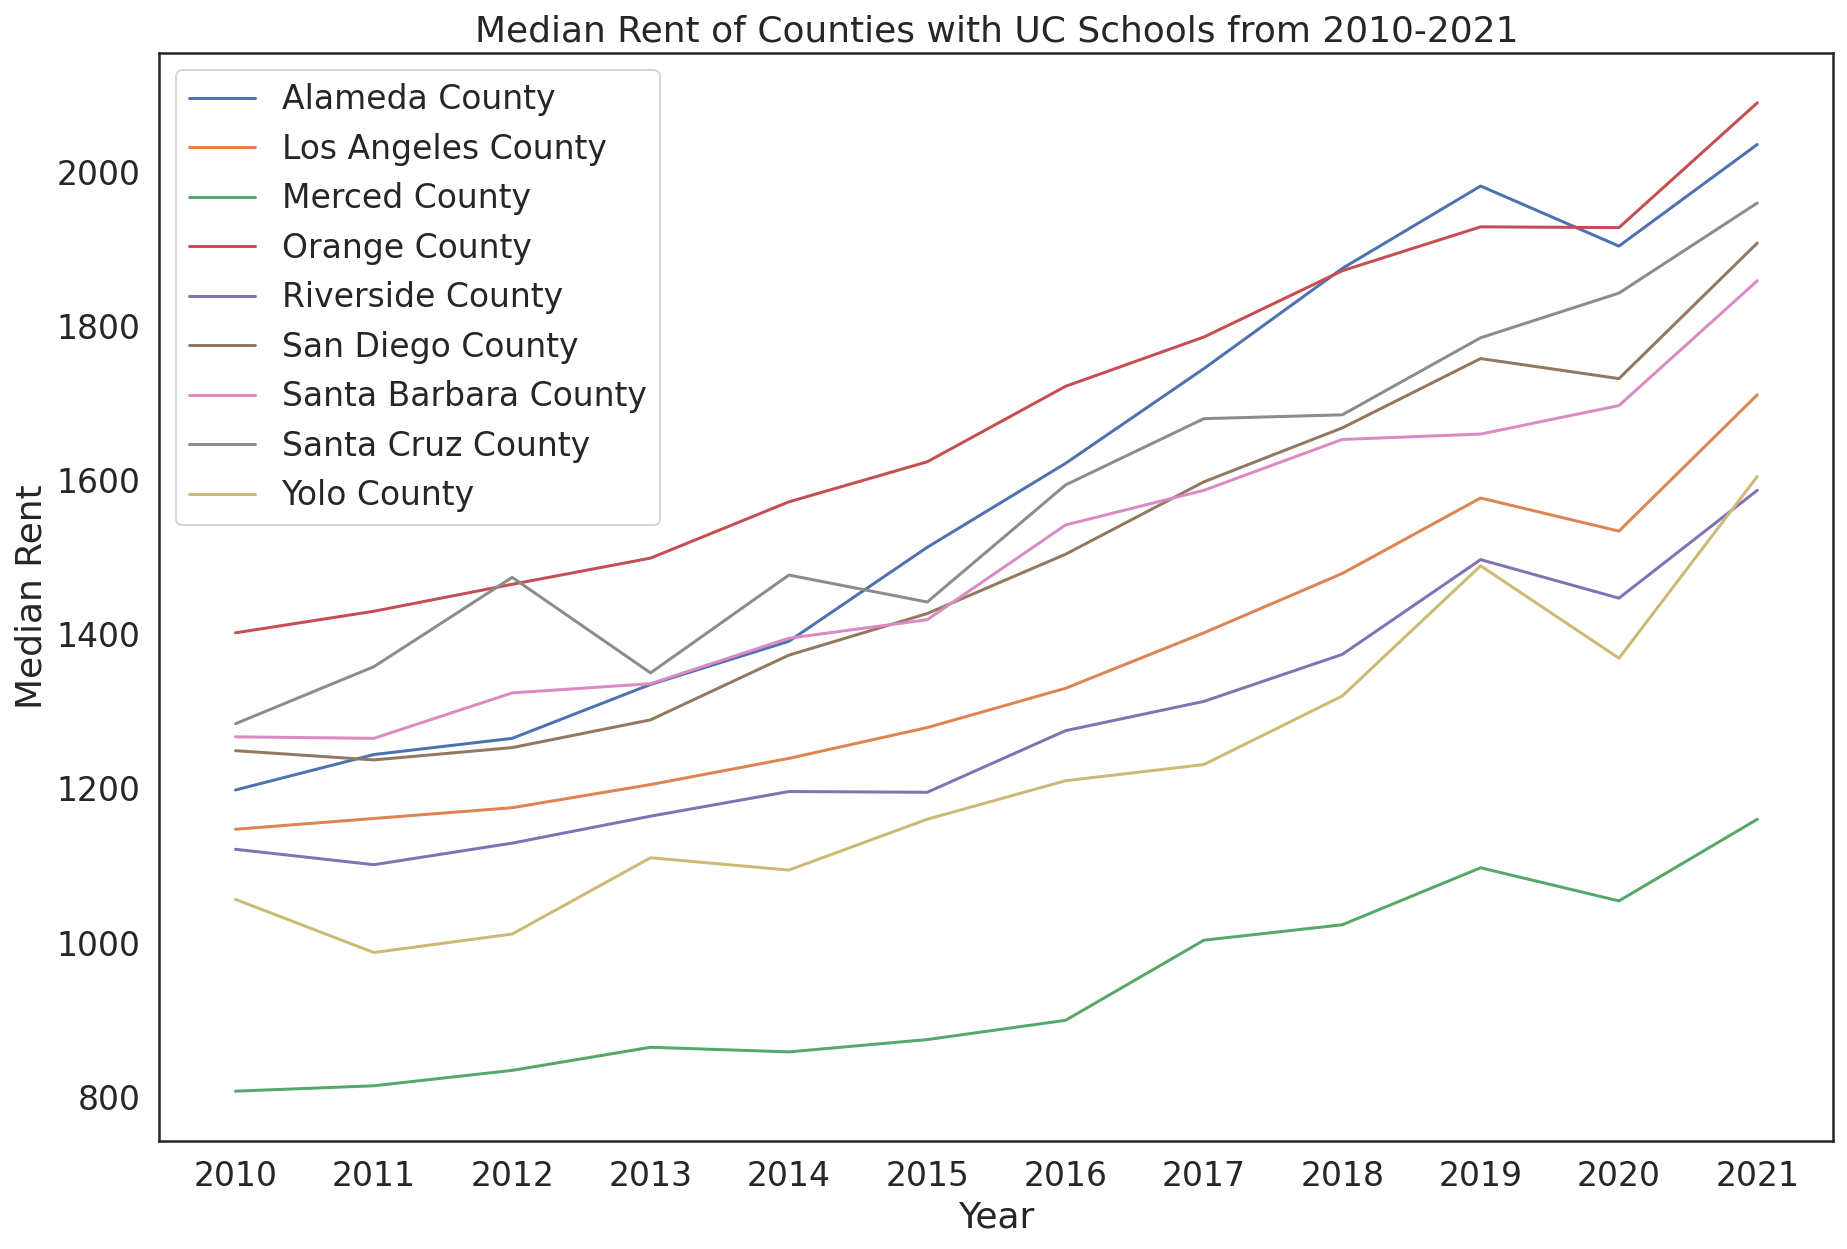

In [54]:
# plot each column into one figure
plt.figure(figsize=(15,10))
plt.xticks(rent_data['Year'])

plot_alam = sns.lineplot(data=rent_data, x='Year', y='Alameda County', label='Alameda County')
plot_lac = sns.lineplot(data=rent_data, x='Year', y='Los Angeles County', label='Los Angeles County')
plot_merc = sns.lineplot(data=rent_data, x='Year', y='Merced County', label='Merced County')
plot_oc = sns.lineplot(data=rent_data, x='Year', y= 'Orange County', label= 'Orange County')
plot_riv = sns.lineplot(data=rent_data, x='Year', y='Riverside County', label='Riverside County')
plot_sdc = sns.lineplot(data=rent_data, x='Year', y='San Diego County', label='San Diego County')
plot_sbc = sns.lineplot(data=rent_data, x='Year', y='Santa Barbara County', label='Santa Barbara County')
plot_scc = sns.lineplot(data=rent_data, x='Year', y='Santa Cruz County', label='Santa Cruz County')
plot_yolo = sns.lineplot(data=rent_data, x='Year', y='Yolo County', label='Yolo County')

plot_alam.set_ylabel('Median Rent')
plot_alam.set_title('Median Rent of Counties with UC Schools from 2010-2021')

rent_plot = plt.gcf()

This ``rent_plot`` was generated to display the trend of median rent of the UC counties. Here, we see that there is an increase in median rent surpassing 2017 in most counties with UC schools except for Santa Cruz, which has a slight dip. Furthermore, there is an interesting **drop in median rent prices from 2019-2020 for all counties**, followed by a **sharp increase in the year 2021**.  

### 1c. College Ranking Data

In [55]:
# describe dataframe
rank_data.describe()

,Year,Berkeley,Los Angeles,Santa Barbara,Irvine,San Diego,Davis,Santa Cruz,Riverside,Merced
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,5.00000
mean,2015.500000,21.000000,22.583333,37.500000,40.916667,38.250000,40.083333,79.916667,103.333333,130.80000
std,3.605551,0.852803,2.065224,4.253341,4.756973,2.895922,2.644319,7.692480,13.593671,29.60912
min,2010.000000,20.000000,19.000000,30.000000,33.000000,35.000000,38.000000,70.000000,85.000000,97.00000
25%,2012.750000,20.000000,20.750000,36.250000,38.250000,36.500000,38.000000,74.250000,93.250000,104.00000
50%,2015.500000,21.000000,23.000000,38.000000,41.500000,37.500000,39.000000,80.000000,99.000000,136.00000
75%,2018.250000,22.000000,24.000000,41.000000,44.250000,39.500000,41.250000,84.250000,114.250000,152.00000
max,2021.000000,22.000000,25.000000,42.000000,49.000000,44.000000,46.000000,97.000000,124.000000,165.00000


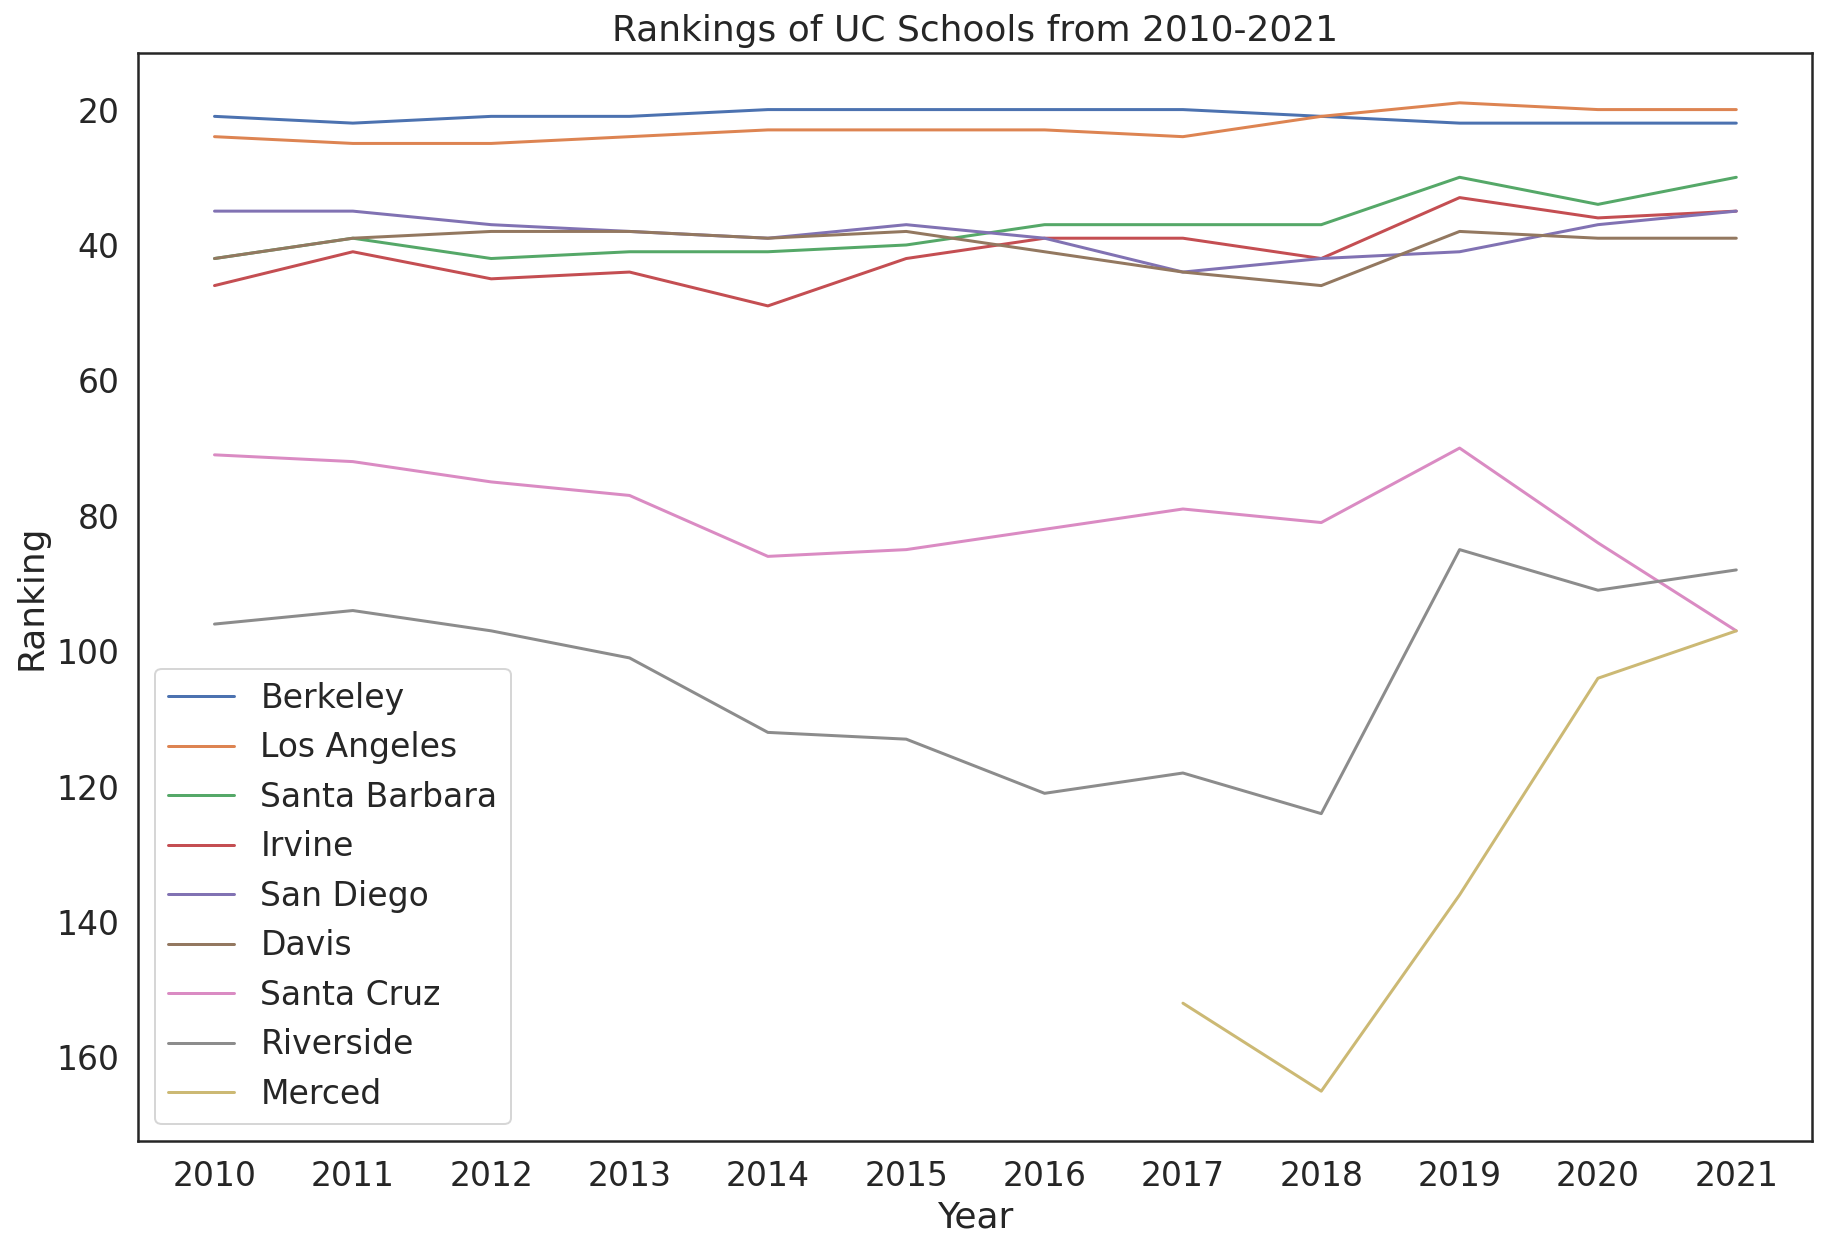

In [56]:
# plot each column into one figure
plt.figure(figsize=(15,10))
plt.xticks(rank_data['Year'])

plot_berk = sns.lineplot(data=rank_data, x='Year', y='Berkeley', label='Berkeley')
plot_la = sns.lineplot(data=rank_data, x='Year', y='Los Angeles', label='Los Angeles')
plot_sb = sns.lineplot(data=rank_data, x='Year', y='Santa Barbara', label='Santa Barbara')
plot_irv = sns.lineplot(data=rank_data, x='Year', y='Irvine', label='Irvine')
plot_sd = sns.lineplot(data=rank_data, x='Year', y='San Diego', label='San Diego')
plot_dav = sns.lineplot(data=rank_data, x='Year', y='Davis', label='Davis')
plot_sc = sns.lineplot(data=rank_data, x='Year', y='Santa Cruz', label='Santa Cruz')
plot_riv = sns.lineplot(data=rank_data, x='Year', y='Riverside', label='Riverside')
plot_merc = sns.lineplot(data=rank_data, x='Year', y='Merced', label='Merced')

plot_berk.invert_yaxis()
plot_berk.set_ylabel('Ranking')
plot_berk.set_title('Rankings of UC Schools from 2010-2021')

rankings_plot = plt.gcf()

This ``rankings_plot`` was created to see the rankings of the different UC schools over time. Notice how the values on the y-axis of this plot are flipped, with the lower numbers situated higher on the axis and higher numbers situated lower on the axis. This is because in assigning rankings, the lower the number the higher the ranking and vice versa. To then show this relationship visually, the numbers had to be arranged from high to low.  

In analyzing this plot then, we see that **the rankings for the UCs have stayed more or less the same**. However, it is important to acknowledge that UC Merced in particular, being a new school, had a rapid increase in ranking  from 2018-2020 which may be explained by its own efforts to raise the school's prestige.

### 1d. Median Household Income Data

In [57]:
Counties_income.describe()

,Year,Alameda,Los Angeles,Merced,Orange,Riverside,San Diego,Santa Barbara,Santa Cruz,Yolo
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,2015.500000,87719.083333,62245.333333,48030.666667,82890.083333,62202.250000,71746.583333,68379.750000,74262.250000,62503.916667
std,3.605551,17474.103059,9318.753100,7304.836049,10969.863374,9540.956595,11322.286546,9985.623977,12379.982597,10285.552625
min,2010.000000,66937.000000,52239.000000,40016.000000,70727.000000,52416.000000,59290.000000,56243.000000,60247.000000,50174.000000
25%,2012.750000,71648.250000,54064.500000,42346.500000,73381.750000,53963.000000,61082.500000,60773.000000,64695.000000,54490.000000
50%,2015.500000,85467.000000,60176.500000,45630.000000,79822.000000,58923.000000,68873.000000,64704.500000,70864.000000,61205.500000
75%,2018.250000,103205.250000,69169.750000,54536.250000,90970.000000,68321.000000,79976.750000,74809.000000,84602.250000,68590.750000
max,2021.000000,113518.000000,77456.000000,59733.000000,100559.000000,79024.000000,91003.000000,86136.000000,93933.000000,80668.000000


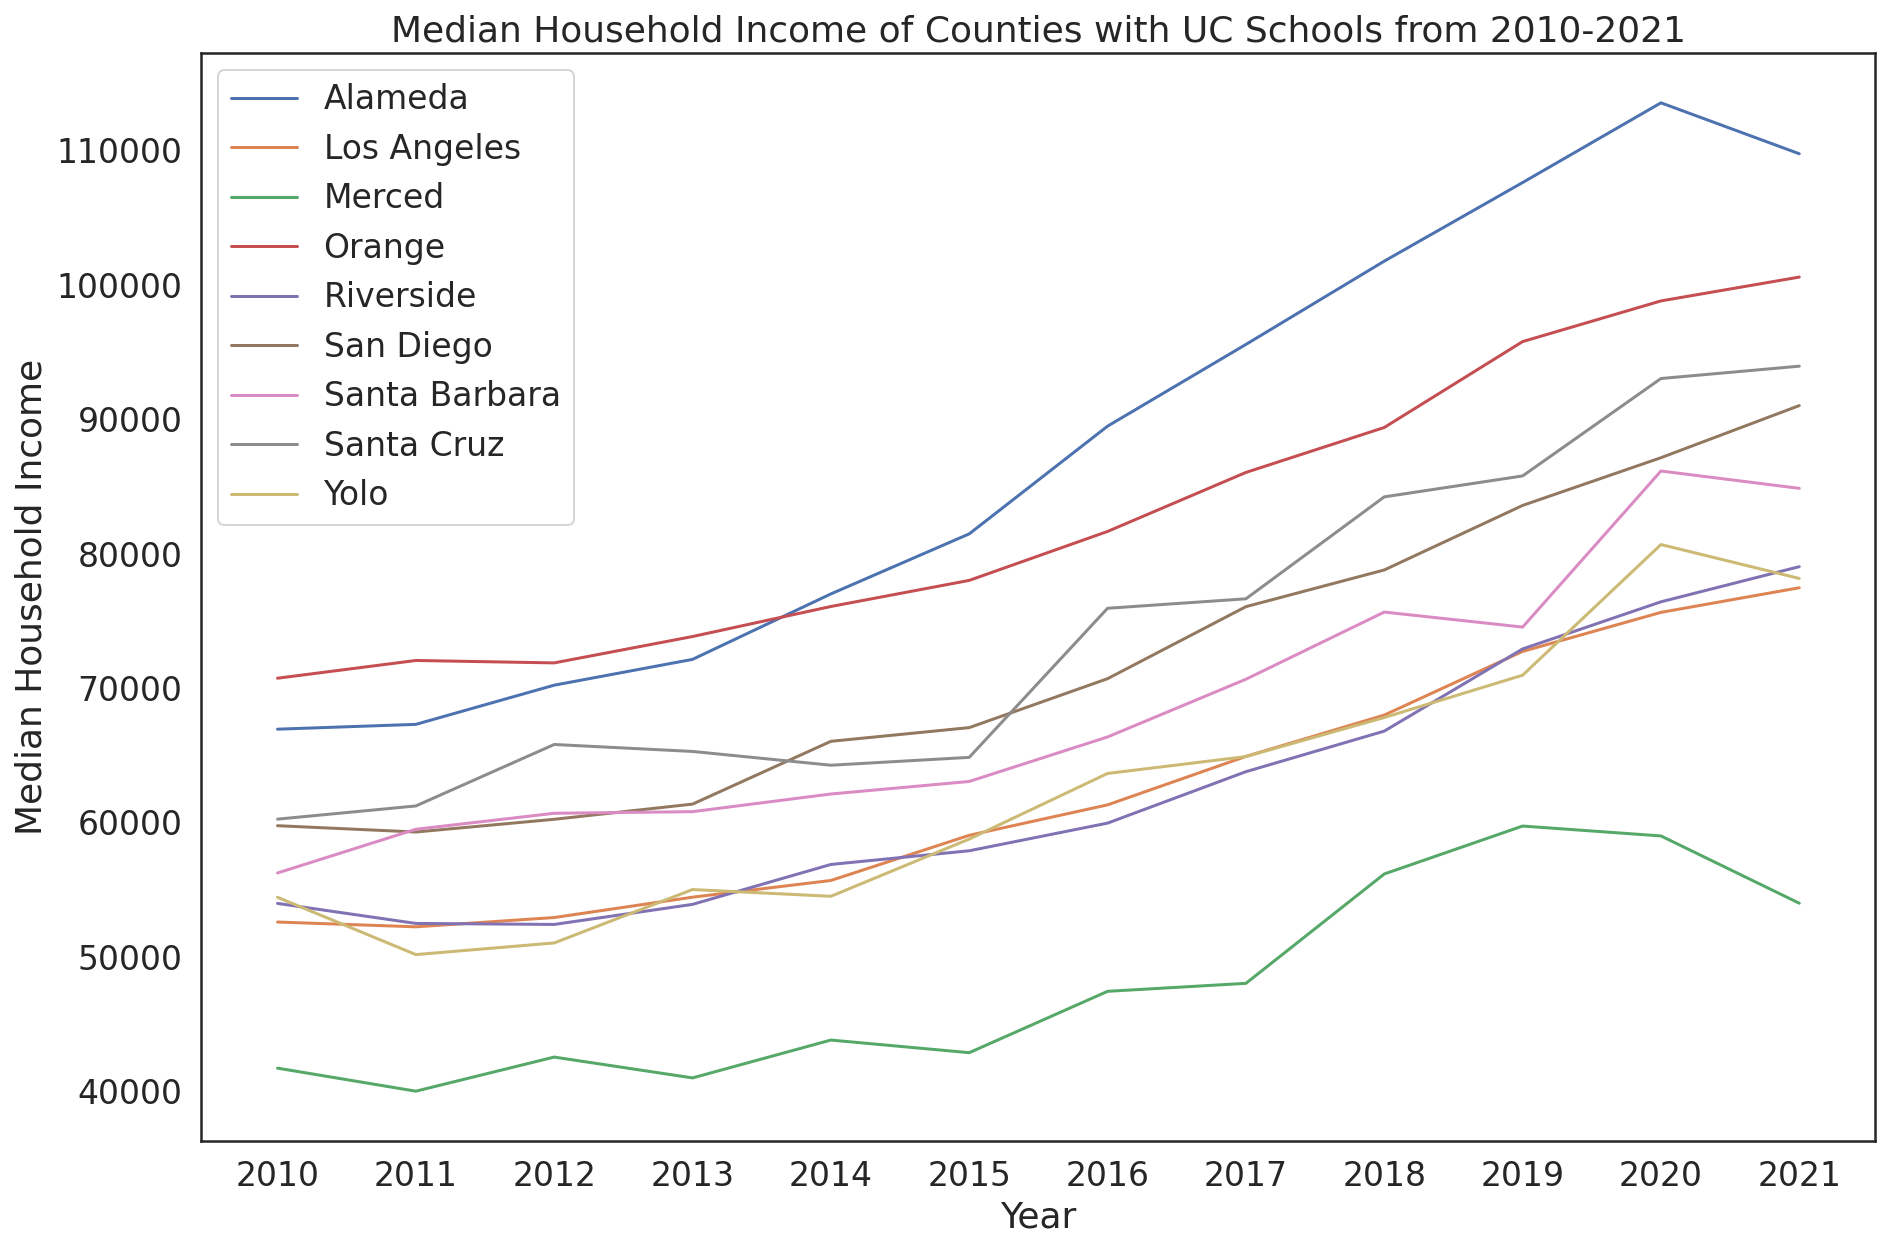

In [58]:
# plot each column into one figure
plt.figure(figsize=(15,10))
plt.xticks(Counties_income['Year'])

inc_alam = sns.lineplot(data=Counties_income, x ='Year', y ='Alameda', label='Alameda')
inc_la = sns.lineplot(data=Counties_income, x ='Year', y ='Los Angeles', label='Los Angeles')
inc_merc = sns.lineplot(data=Counties_income, x ='Year', y ='Merced', label='Merced')
inc_oc = sns.lineplot(data=Counties_income, x ='Year', y ='Orange', label='Orange')
inc_riv = sns.lineplot(data=Counties_income, x ='Year', y ='Riverside', label='Riverside')
inc_sd = sns.lineplot(data=Counties_income, x ='Year', y ='San Diego', label='San Diego')
inc_sb = sns.lineplot(data=Counties_income, x ='Year', y ='Santa Barbara', label='Santa Barbara')
inc_sc = sns.lineplot(data=Counties_income, x ='Year', y ='Santa Cruz', label='Santa Cruz')
inc_yolo = sns.lineplot(data=Counties_income, x ='Year', y ='Yolo', label='Yolo')

inc_alam.set_ylabel('Median Household Income')
inc_alam.set_title('Median Household Income of Counties with UC Schools from 2010-2021')

income_plot = plt.gcf()

The ``income_plot`` was produced to see the trend of a county's median household income from 2010-2021. Here, we observe that there is a general increase in the median household income, despite fluctuations, from 2010-2018. In 2019, however, it seems that Merced County had a decrease in household income while the rest of the counties saw an increase in varying extents. Lastly, **from 2020-2021 there appears to be much more counties with a decrease in household income (Merced, Yolo, Santa Barabara, and Alameda)** than previous years. 

## 2. Data Analysis

This section analyzes the datasets we have described by comparing them to our variable of interest: rent data. This is done by generating compare plots and pbserving their general trends relative to each other.

### 2a. Comparing New Enrollees and Rent Data

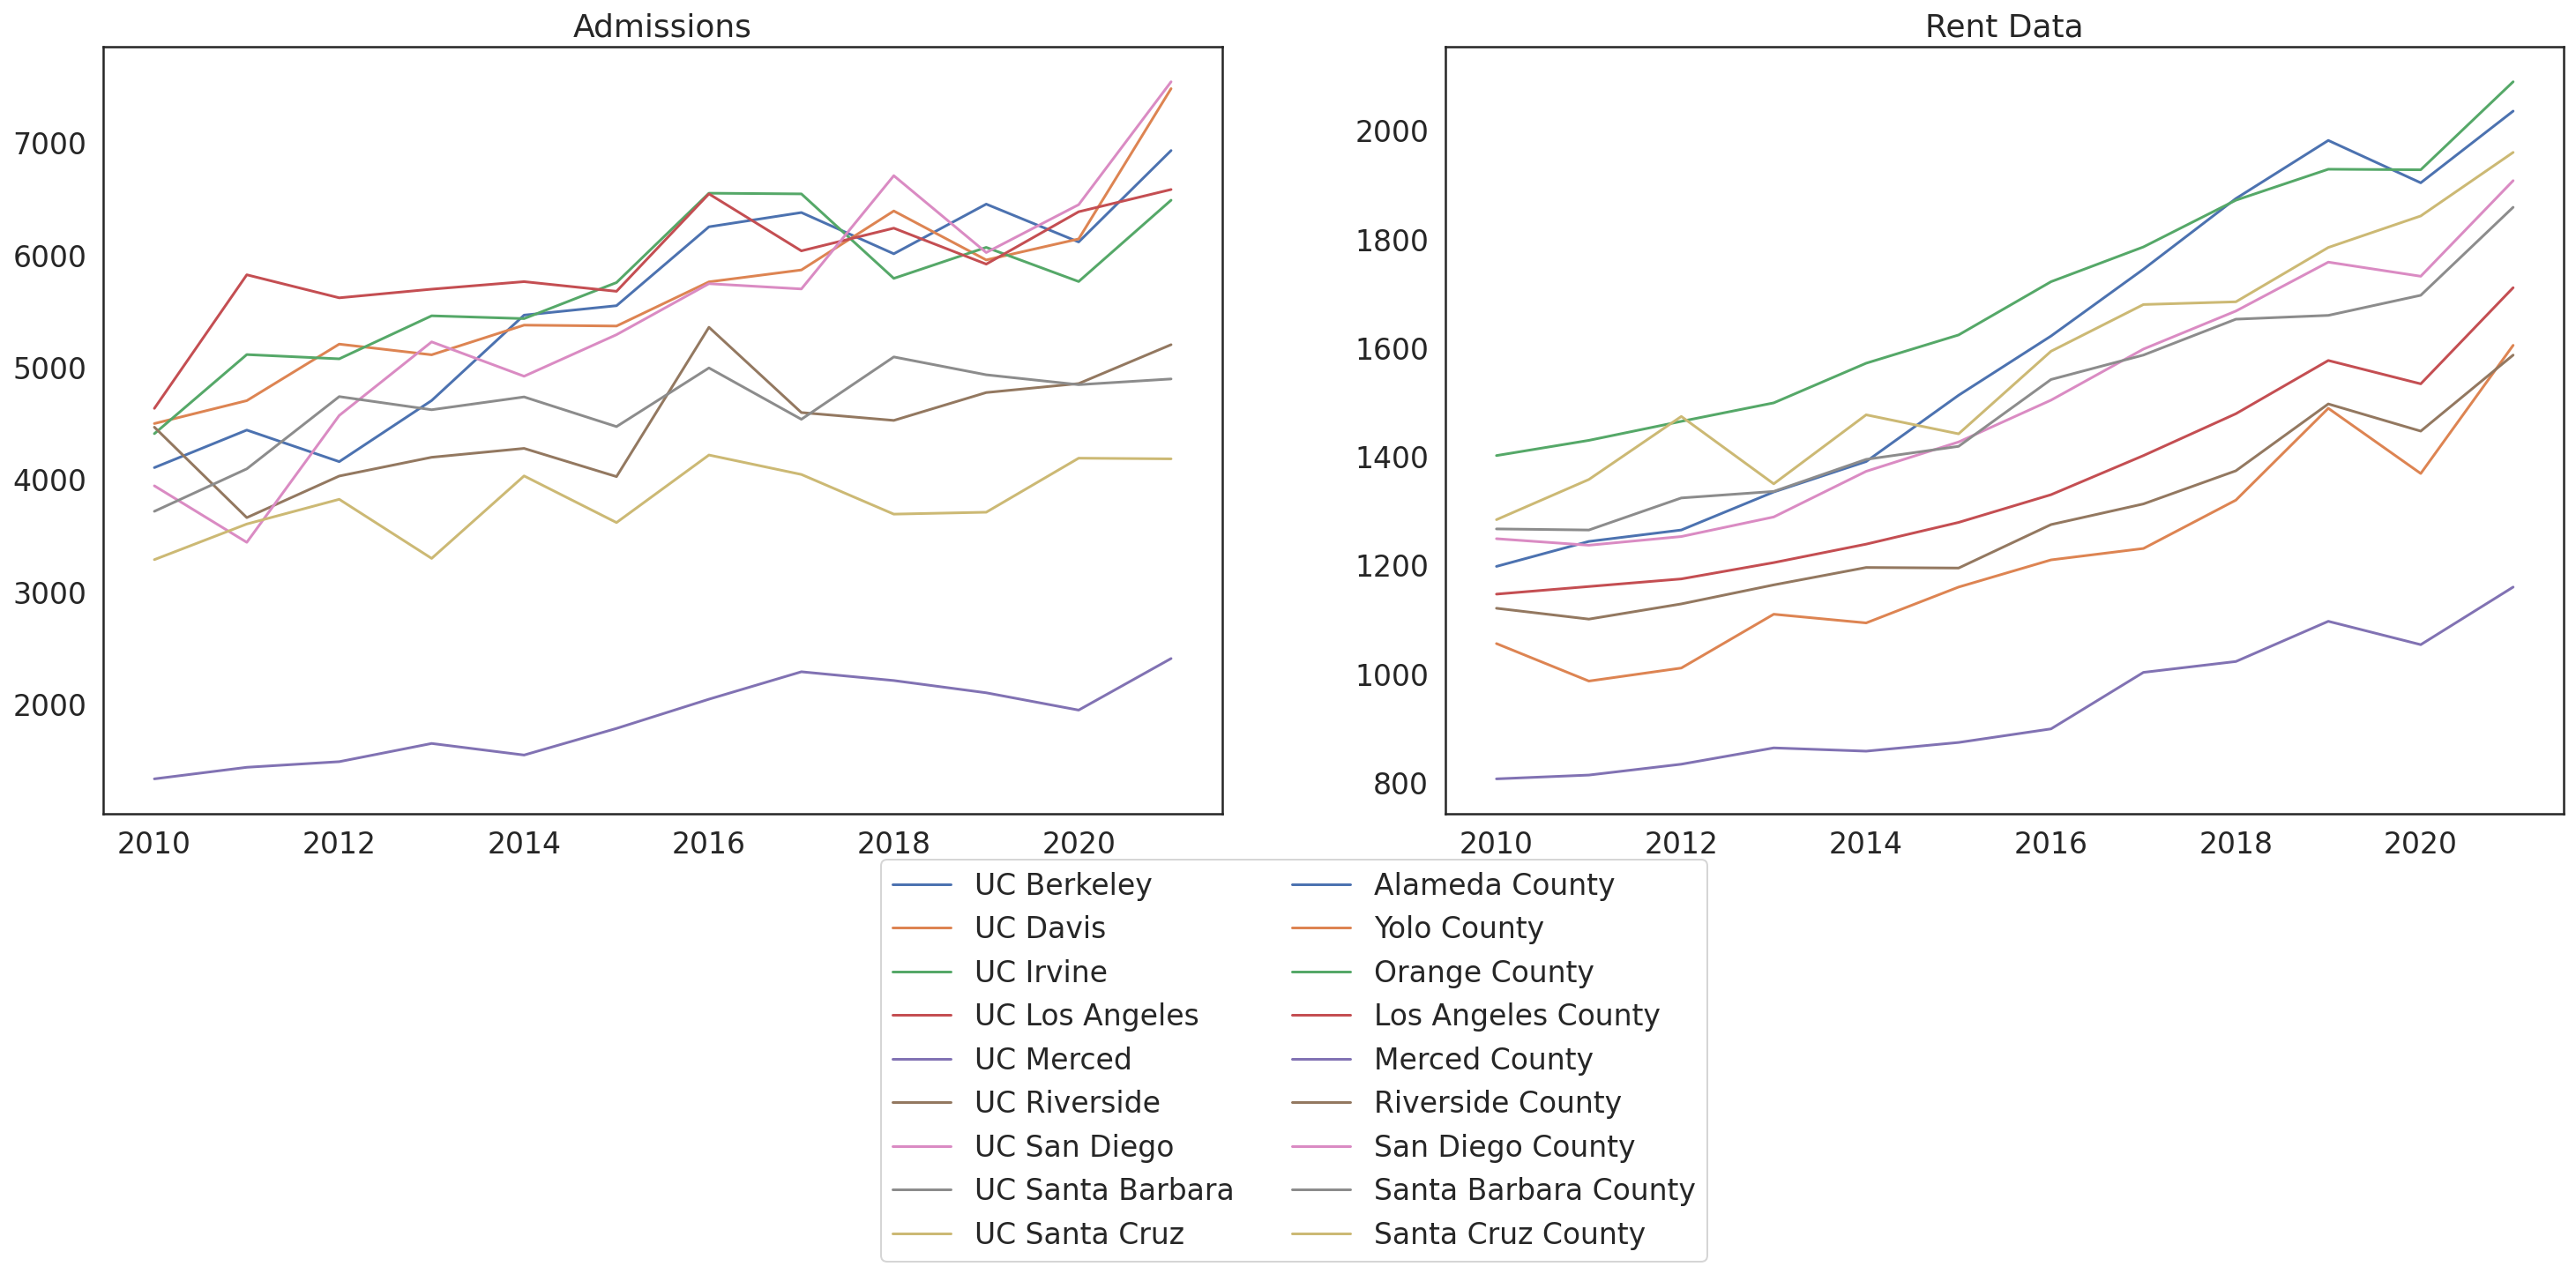

In [59]:
fig1, axes1 = plt.subplots(nrows=1, ncols=2, figsize=(25, 8))
  
# Plotting Enrollment Data in the First Column
axes1[0].plot(UC_admissions['Year'], UC_admissions['Berkeley Enrolls'], label='UC Berkeley')
axes1[0].plot(UC_admissions['Year'], UC_admissions['Davis Enrolls'], label='UC Davis')
axes1[0].plot(UC_admissions['Year'], UC_admissions['Irvine Enrolls'], label='UC Irvine')
axes1[0].plot(UC_admissions['Year'], UC_admissions['Los Angeles Enrolls'], label='UC Los Angeles')
axes1[0].plot(UC_admissions['Year'], UC_admissions['Merced Enrolls'], label='UC Merced')
axes1[0].plot(UC_admissions['Year'], UC_admissions['Riverside Enrolls'], label='UC Riverside')
axes1[0].plot(UC_admissions['Year'], UC_admissions['San Diego Enrolls'], label='UC San Diego')
axes1[0].plot(UC_admissions['Year'], UC_admissions['Santa Barbara Enrolls'], label='UC Santa Barbara')
axes1[0].plot(UC_admissions['Year'], UC_admissions['Santa Cruz Enrolls'], label='UC Santa Cruz')
axes1[0].set_title("Admissions")

# Plotting Rent Data in the Second Column
axes1[1].plot(rent_data['Year'], rent_data['Alameda County'], label='Alameda County')
axes1[1].plot(rent_data['Year'], rent_data['Yolo County'], label='Yolo County')
axes1[1].plot(rent_data['Year'], rent_data['Orange County'], label='Orange County')
axes1[1].plot(rent_data['Year'], rent_data['Los Angeles County'], label='Los Angeles County')
axes1[1].plot(rent_data['Year'], rent_data['Merced County'], label='Merced County')
axes1[1].plot(rent_data['Year'], rent_data['Riverside County'], label='Riverside County')
axes1[1].plot(rent_data['Year'], rent_data['San Diego County'], label='San Diego County')
axes1[1].plot(rent_data['Year'], rent_data['Santa Barbara County'], label='Santa Barbara County')
axes1[1].plot(rent_data['Year'], rent_data['Santa Cruz County'], label='Santa Cruz County')
axes1[1].set_title("Rent Data")

# Create Legend for the Plot
lines = []
labels = []
for axes in fig1.axes:
    Line, Label = axes.get_legend_handles_labels()
    lines.extend(Line)
    labels.extend(Label)
fig1.legend(lines, labels, ncol=2, loc='lower center', bbox_to_anchor=(0.5, -0.33))

# Combine all the operations and display
plt.show()

1. __Reasoning for Comparisons__: The more students an university accepts, the more demand there is for housing in the surrounding region. This is since the area will become more populated and as a result of higher demand, the housing market will increase its price to provide housing to those who can outcompete and provide its value. 
2. __Meaning of Results__: Though rocky throughout the years with inclines and declines, both graphs generally have an upward trend; this can be used to prove our claim that an increase in admissions correlates with an increase in rent. All the UCs we studied follow this trend. One factor we believe can truly prove their correlation is the comparison between 2020 admissions and 2020 rent. Both graphs rapidly decline in their numbers, proving that admissions numbers are truly correlated with rent changes. 

### 2b. Comparing Median Household Income and Rent Data

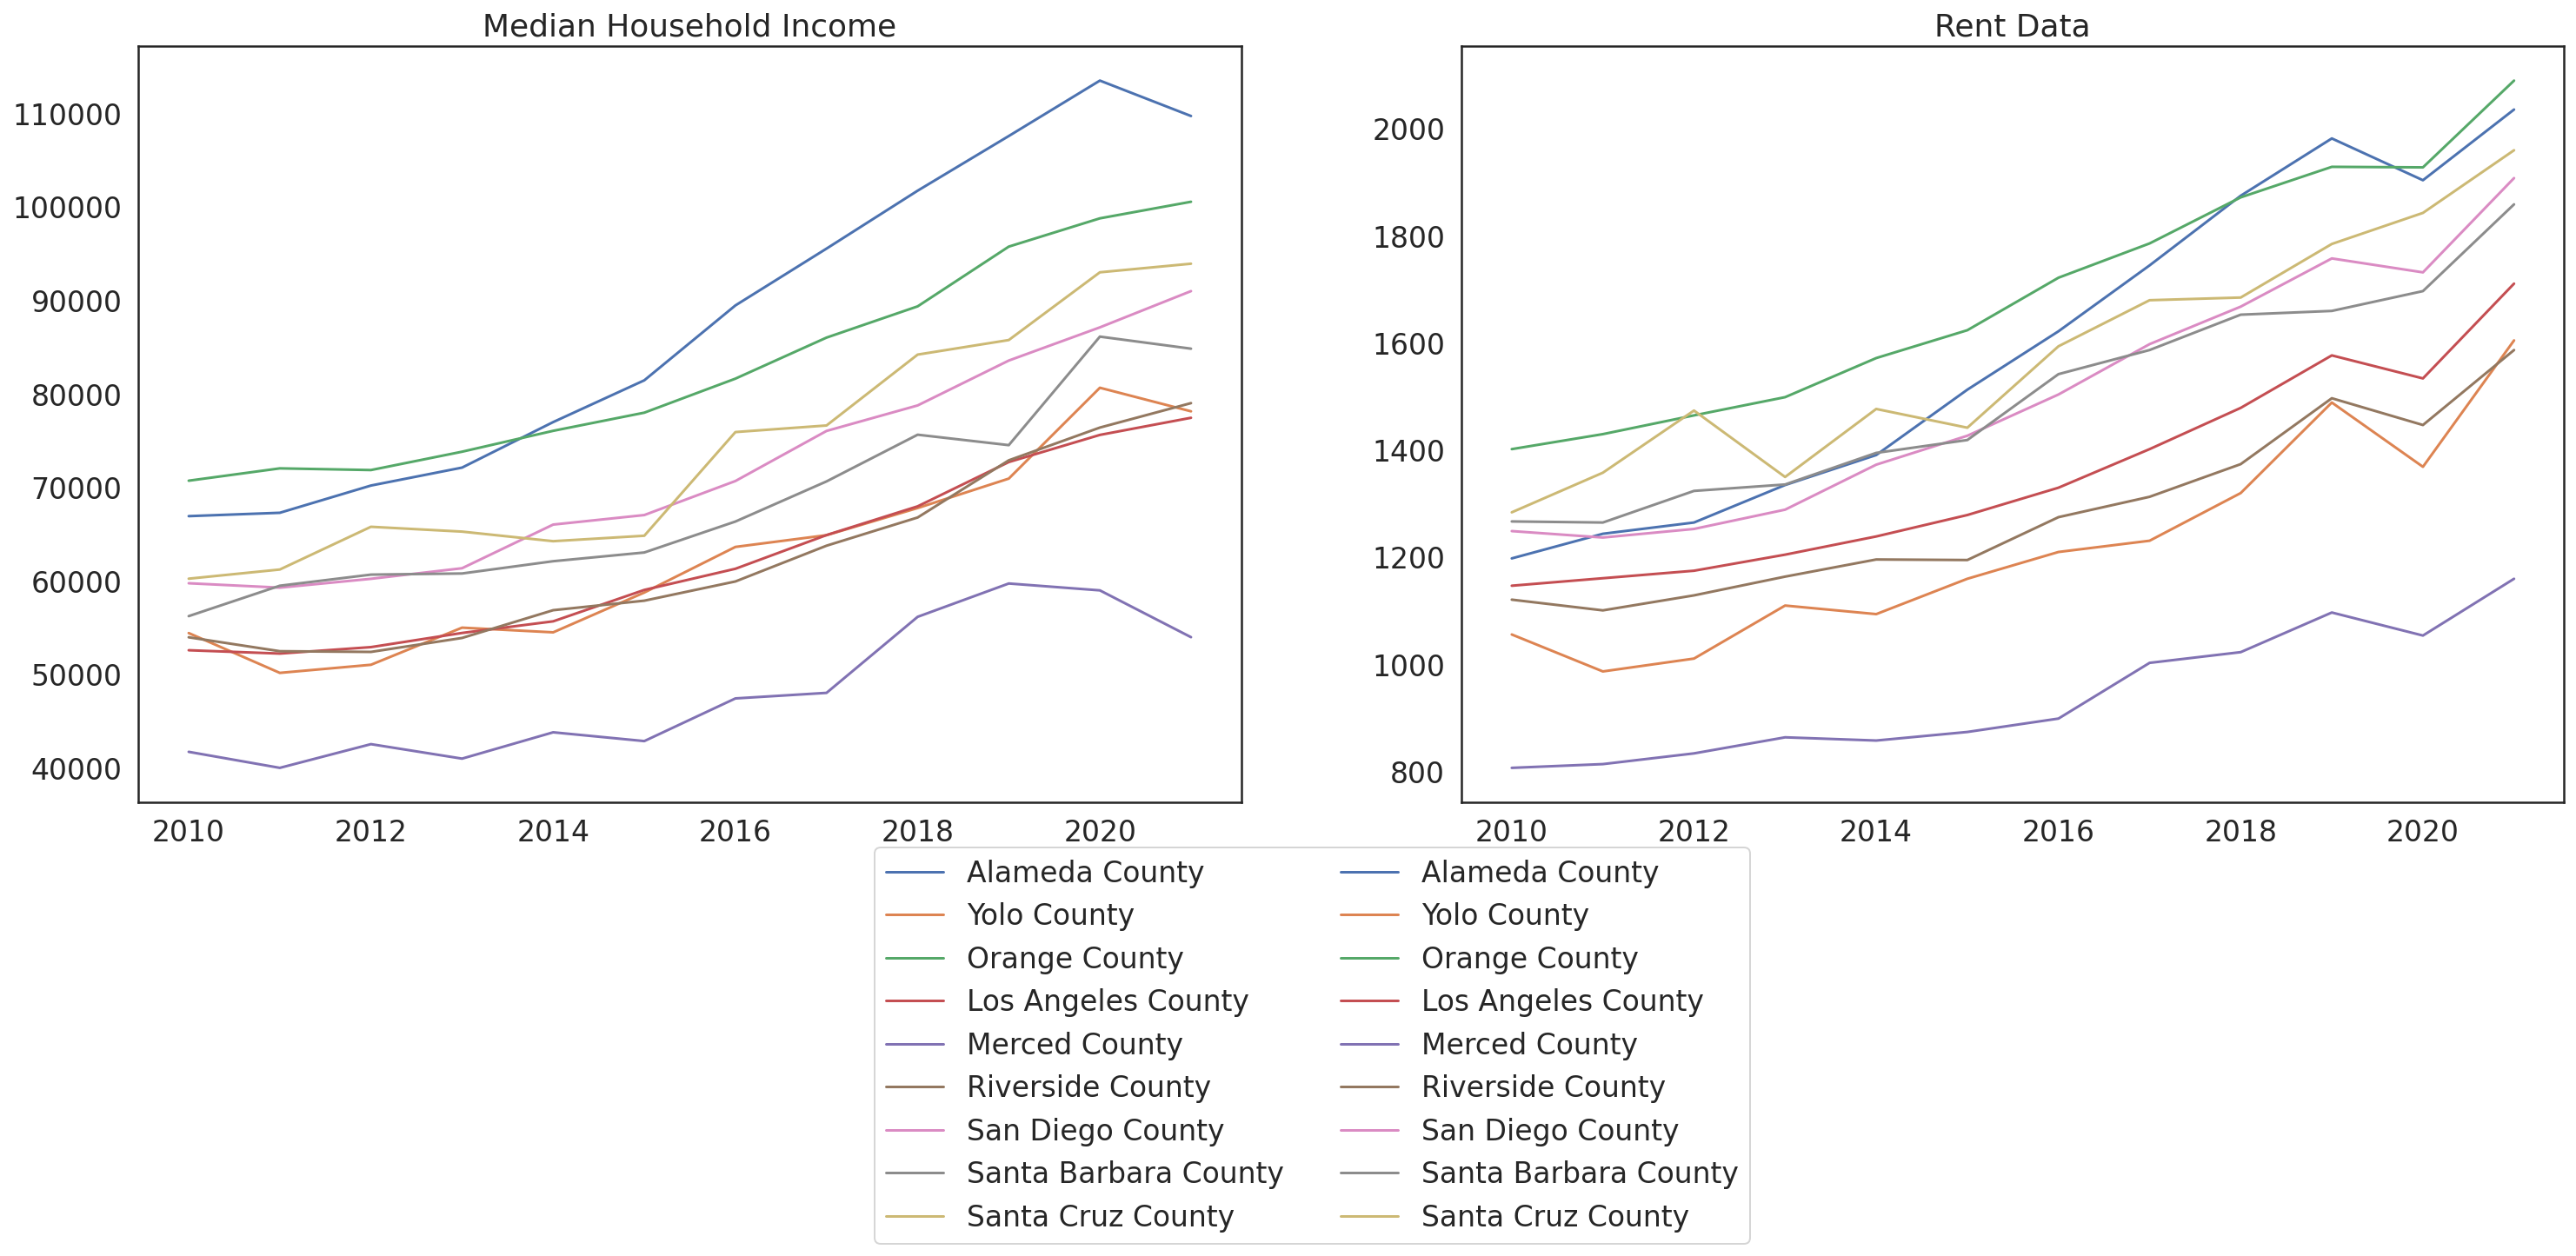

In [60]:
fig2, axes2 = plt.subplots(nrows=1, ncols=2, figsize=(25, 8))
  
# Plotting Median Household Income Data in the First Column
axes2[0].plot(Counties_income['Year'], Counties_income['Alameda'], label='Alameda County')
axes2[0].plot(Counties_income['Year'], Counties_income['Yolo'], label='Yolo County')
axes2[0].plot(Counties_income['Year'], Counties_income['Orange'], label='Orange County')
axes2[0].plot(Counties_income['Year'], Counties_income['Los Angeles'], label='Los Angeles County')
axes2[0].plot(Counties_income['Year'], Counties_income['Merced'], label='Merced County')
axes2[0].plot(Counties_income['Year'], Counties_income['Riverside'], label='Riverside County')
axes2[0].plot(Counties_income['Year'], Counties_income['San Diego'], label='San Diego County')
axes2[0].plot(Counties_income['Year'], Counties_income['Santa Barbara'], label='Santa Barbara County')
axes2[0].plot(Counties_income['Year'], Counties_income['Santa Cruz'], label='Santa Cruz County')
axes2[0].set_title("Median Household Income")

# Plotting Rent Data in the Second Column
axes2[1].plot(rent_data['Year'], rent_data['Alameda County'], label='Alameda County')
axes2[1].plot(rent_data['Year'], rent_data['Yolo County'], label='Yolo County')
axes2[1].plot(rent_data['Year'], rent_data['Orange County'], label='Orange County')
axes2[1].plot(rent_data['Year'], rent_data['Los Angeles County'], label='Los Angeles County')
axes2[1].plot(rent_data['Year'], rent_data['Merced County'], label='Merced County')
axes2[1].plot(rent_data['Year'], rent_data['Riverside County'], label='Riverside County')
axes2[1].plot(rent_data['Year'], rent_data['San Diego County'], label='San Diego County')
axes2[1].plot(rent_data['Year'], rent_data['Santa Barbara County'], label='Santa Barbara County')
axes2[1].plot(rent_data['Year'], rent_data['Santa Cruz County'], label='Santa Cruz County')
axes2[1].set_title("Rent Data")

# Create Legend for the Plot
lines = []
labels = []
for axes in fig2.axes:
    Line, Label = axes.get_legend_handles_labels()
    lines.extend(Line)
    labels.extend(Label)
fig2.legend(lines, labels, ncol=2, loc='lower center', bbox_to_anchor=(0.5, -0.33))
  
# Combine all the operations and display
plt.show()

1. __Reasoning for Comparisons__: Median household income has always influenced rent data; it is a subccategory of economic growth. The higher the median household income, the higher the prices in the housing market. This is because a higher mean income signifies that people have more money to spend lavishly. Thus, the housing market adjusts with an upward trend to reflect this increase. 
2. __Meaning of Results__: The median household income in all the counties we studied show a steady and almost smooth increase in income with the exception of 2020; the households in most counties take a dip in income with the exception of Orange County, Los Angeles County, and San Diego County. Rent data demonstrates a mostly upward trend with the exception of 2020, in which rent falls. Once again, the similarities in trends goes to show that median household income could influence the housing market (with the exception of a few financially stable, middle-class counties). 

### 2c. Comparing Rank and Rent Data

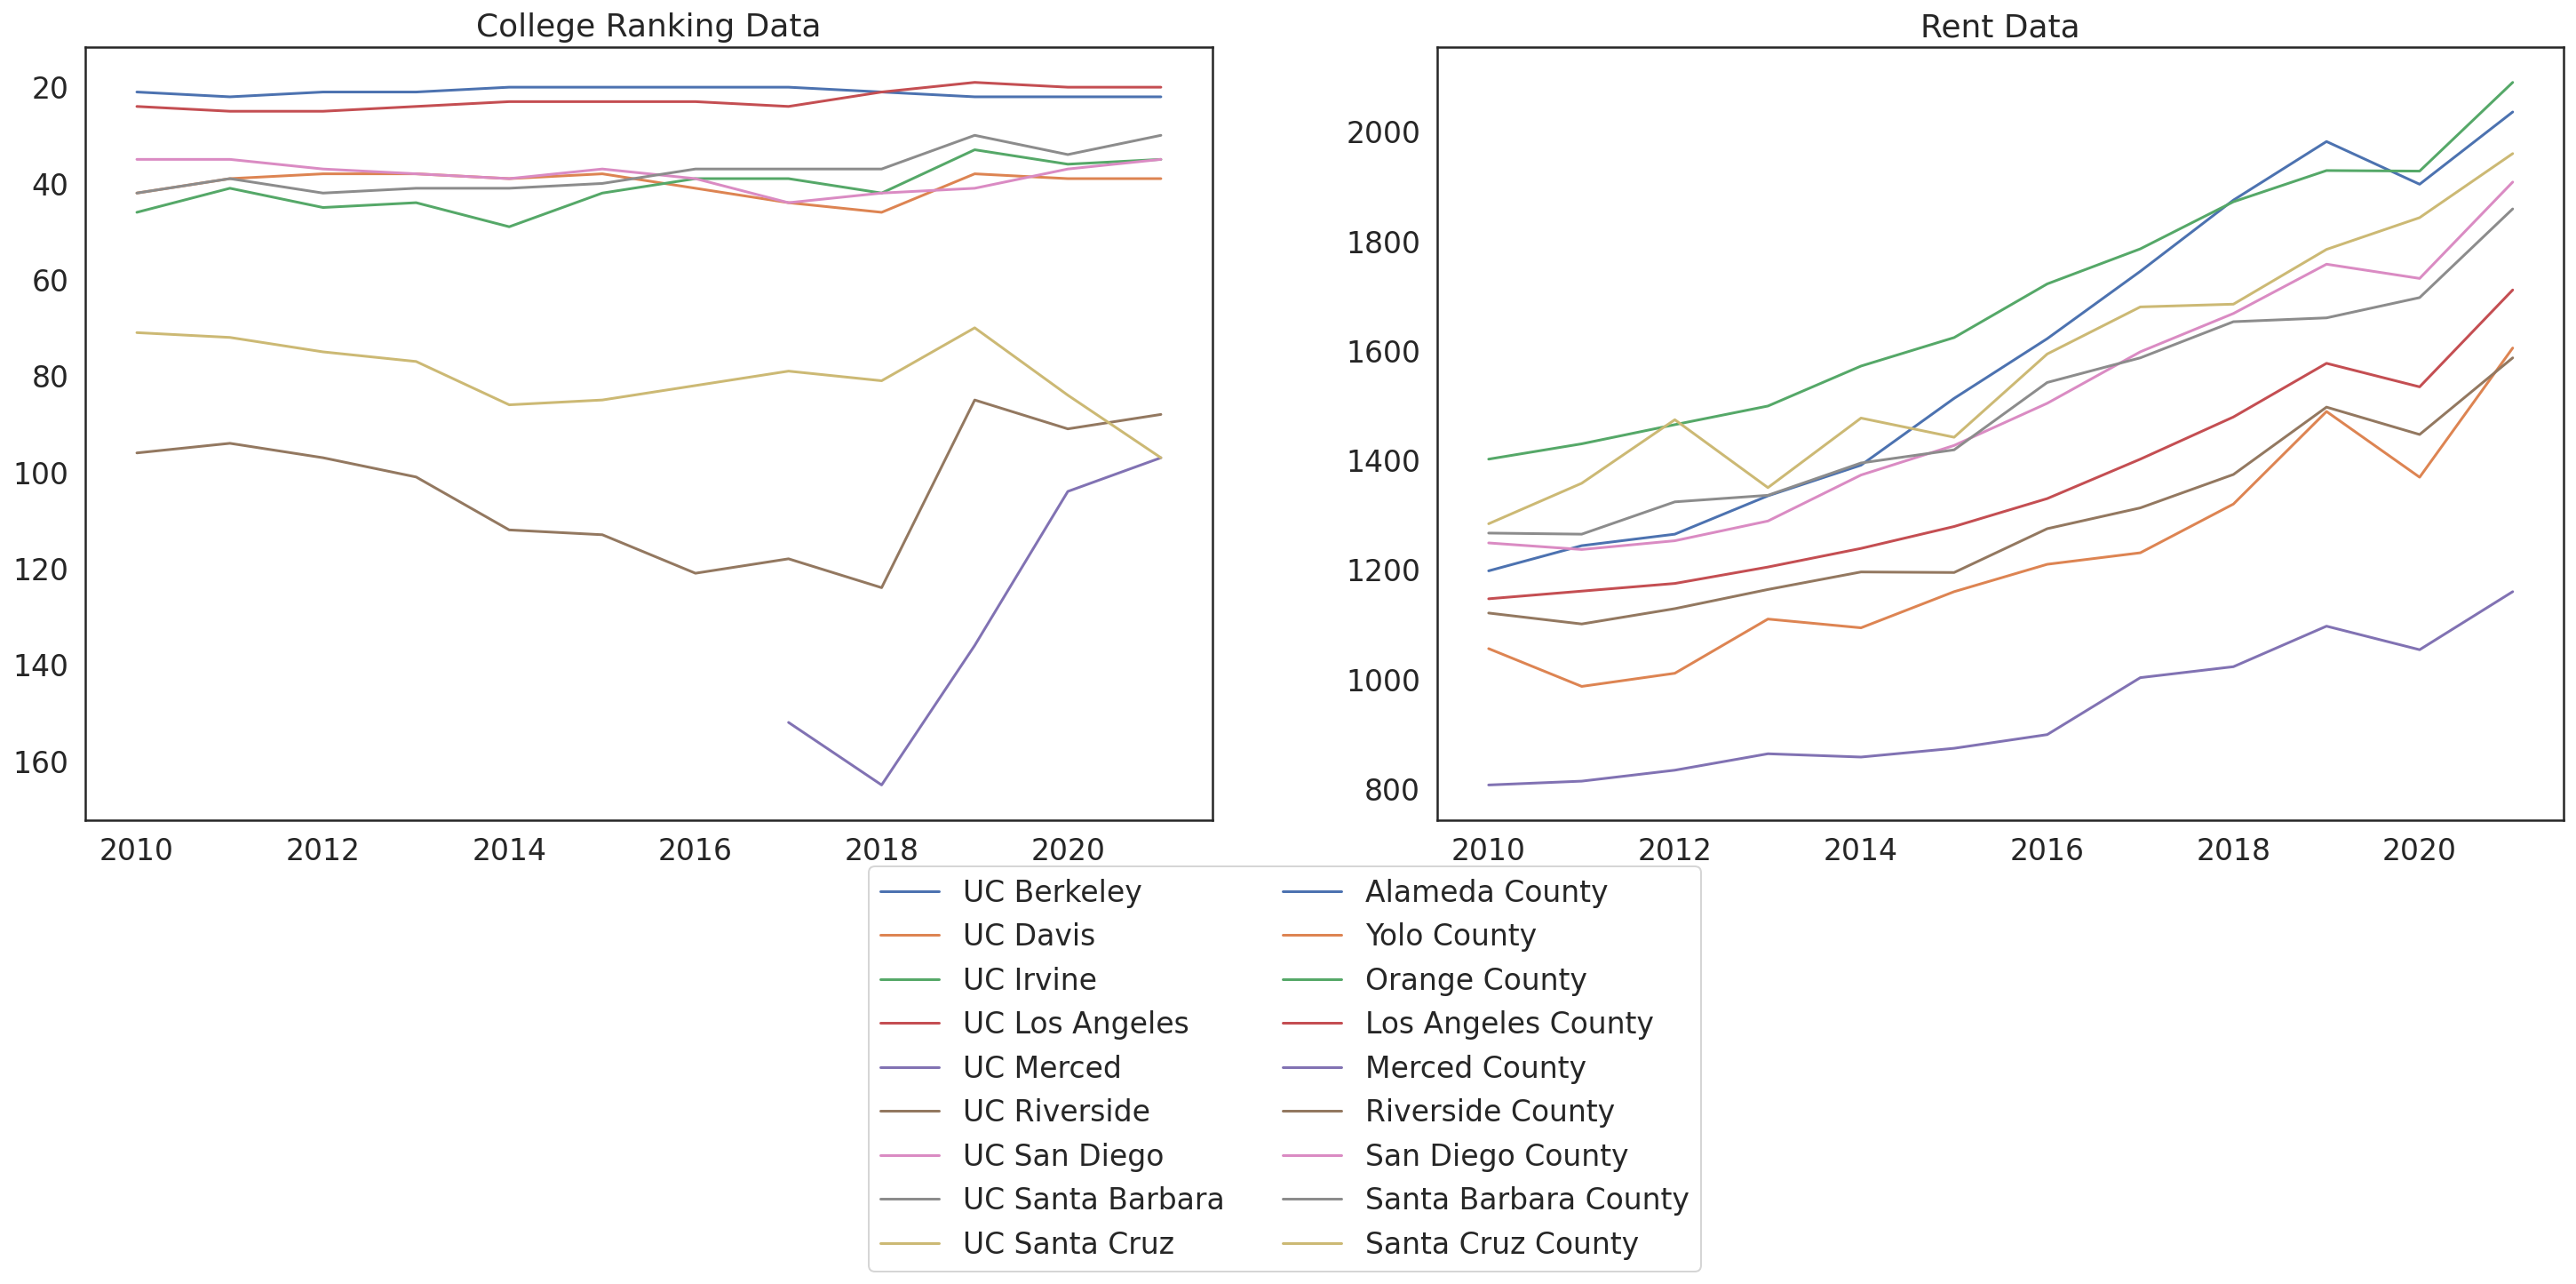

In [61]:
fig3, axes3 = plt.subplots(nrows=1, ncols=2, figsize=(25, 8))
axes3[0].invert_yaxis()


# Plotting Median Household Income Data in the First Column
axes3[0].plot(rank_data['Year'], rank_data['Berkeley'], label='UC Berkeley')
axes3[0].plot(rank_data['Year'], rank_data['Davis'], label='UC Davis')
axes3[0].plot(rank_data['Year'], rank_data['Irvine'], label='UC Irvine')
axes3[0].plot(rank_data['Year'], rank_data['Los Angeles'], label='UC Los Angeles')
axes3[0].plot(rank_data['Year'], rank_data['Merced'], label='UC Merced')
axes3[0].plot(rank_data['Year'], rank_data['Riverside'], label='UC Riverside')
axes3[0].plot(rank_data['Year'], rank_data['San Diego'], label='UC San Diego')
axes3[0].plot(rank_data['Year'], rank_data['Santa Barbara'], label='UC Santa Barbara')
axes3[0].plot(rank_data['Year'], rank_data['Santa Cruz'], label='UC Santa Cruz')
axes3[0].set_title("College Ranking Data")

# Plotting Rent Data in the Second Column
axes3[1].plot(rent_data['Year'], rent_data['Alameda County'], label='Alameda County')
axes3[1].plot(rent_data['Year'], rent_data['Yolo County'], label='Yolo County')
axes3[1].plot(rent_data['Year'], rent_data['Orange County'], label='Orange County')
axes3[1].plot(rent_data['Year'], rent_data['Los Angeles County'], label='Los Angeles County')
axes3[1].plot(rent_data['Year'], rent_data['Merced County'], label='Merced County')
axes3[1].plot(rent_data['Year'], rent_data['Riverside County'], label='Riverside County')
axes3[1].plot(rent_data['Year'], rent_data['San Diego County'], label='San Diego County')
axes3[1].plot(rent_data['Year'], rent_data['Santa Barbara County'], label='Santa Barbara County')
axes3[1].plot(rent_data['Year'], rent_data['Santa Cruz County'], label='Santa Cruz County')
axes3[1].set_title("Rent Data")

# Create Legend for the Plot
lines = []
labels = []
for axes in fig3.axes:
    Line, Label = axes.get_legend_handles_labels()
    lines.extend(Line)
    labels.extend(Label)
fig3.legend(lines, labels, ncol=2, loc='lower center', bbox_to_anchor=(0.5, -0.33))
  
# Combine all the operations and display
plt.show()

1. __Reasoning for Comparisons__: We believe rank correlates with the population of students. The higher an university ranks, the more people would be inclined to apply to it. Moreover, university rank correlates with the work the university does in its area (research, outreach, community support). This, consequently, increases the population in the area. An increased population in the area means the housing market will increase its price to meet the increase in demand. 
2. __Meaning of Results__: We can see that most colleges, with the exception of UC Santa Cruz, stood at the same ranking or increased in ranking. Again, we know that rent prices have been steadily increasing for the past few years. Thus, even though ranking is slowly increasing, the stagnant trend for college ranking may go to show that ranking may not have as profound of an effect on rent as we had expected.  